## Importing Libraries & Reading CSV File:



In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.stats import kruskal
from scipy.stats import norm
import numpy as np

To begin, we will make further modifications to our dataset, namely:

- drop all date and id columns
- creating a 'mortality_flag' column which will provide a binary indicator if a patient has died or not
- grouping races into more generalized categories: white, black, hispanic, asian, native pacific islander, other, unknown
- grouping admission type into emergency or observational cause
- shortening emergency admission location titles
- converting all categorical columns into one hot encoding format

In [13]:
# Load the dataset
icu_sp = pd.read_csv('ICU_SPINAL_PATIENT_FEATURES_VITALS_EXT.csv')

# Create a mortality flag
icu_sp['mortality_flag'] = icu_sp['dod'].notna().astype(int)

# --- Grouping 'long_title' ---
# Get the frequency of each injury type
long_title_counts = icu_sp['long_title'].value_counts()

# Identify titles that occur less than 10 times
rare_titles = long_title_counts[long_title_counts < 10].index
not_rare_titles = long_title_counts[long_title_counts >= 10].index

# Replace rare titles with "Rare Injury"
icu_sp['long_title_grouped'] = icu_sp['long_title'].apply(lambda x: 'Rare Injury' if x in rare_titles else x)


# --- Grouping 'race' ---
race_mapping = {
    'WHITE': 'White',
    'WHITE - OTHER EUROPEAN': 'White',
    'WHITE - RUSSIAN': 'White',
    'WHITE - BRAZILIAN': 'White',
    'WHITE - EASTERN EUROPEAN': 'White',

    'BLACK/AFRICAN AMERICAN': 'Black',
    'BLACK/CAPE VERDEAN': 'Black',
    'BLACK/CARIBBEAN ISLAND': 'Black',
    'BLACK/AFRICAN': 'Black',

    'HISPANIC OR LATINO': 'Hispanic',
    'HISPANIC/LATINO - PUERTO RICAN': 'Hispanic',
    'HISPANIC/LATINO - DOMINICAN': 'Hispanic',
    'HISPANIC/LATINO - GUATEMALAN': 'Hispanic',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'Hispanic',
    'HISPANIC/LATINO - SALVADORAN': 'Hispanic',
    'HISPANIC/LATINO - HONDURAN': 'Hispanic',
    'HISPANIC/LATINO - CUBAN': 'Hispanic',
    'HISPANIC/LATINO - COLUMBIAN': 'Hispanic',
    'HISPANIC/LATINO - MEXICAN': 'Hispanic',

    'ASIAN': 'Asian',
    'ASIAN - CHINESE': 'Asian',
    'ASIAN - ASIAN INDIAN': 'Asian',
    'ASIAN - SOUTH EAST ASIAN': 'Asian',
    'ASIAN - KOREAN': 'Asian',

    'AMERICAN INDIAN/ALASKA NATIVE': 'Native American or Pacific Islander',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'Native American or Pacific Islander',

    'OTHER': 'Other',
    'PORTUGUESE': 'Other',
    'SOUTH AMERICAN': 'Other',
    'MULTIPLE RACE/ETHNICITY': 'Other',

    'UNKNOWN': 'Unknown',
    'UNABLE TO OBTAIN': 'Unknown',
    'PATIENT DECLINED TO ANSWER': 'Unknown',
}

icu_sp['race_grouped'] = icu_sp['race'].map(race_mapping).fillna('Other')


# --- Grouping 'admission_type' ---
admission_type_mapping = {
    'EW EMER.': 'EMERGENCY',
    'DIRECT EMER.': 'EMERGENCY',
    'EU OBSERVATION': 'OBSERVATION',
    'OBSERVATION ADMIT': 'OBSERVATION',
    'DIRECT OBSERVATION': 'OBSERVATION',
    'AMBULATORY OBSERVATION': 'OBSERVATION',
    'SURGICAL SAME DAY ADMISSION': 'SURGICAL',
    'ELECTIVE': 'ELECTIVE',
    'URGENT': 'URGENT'
}

icu_sp['admission_type_grouped'] = icu_sp['admission_type'].map(admission_type_mapping).fillna('OTHER')

# --- Grouping 'admission_location' ---
admission_location_mapping = {
    'EMERGENCY ROOM': 'EMERGENCY',
    'PACU': 'EMERGENCY',
    'TRANSFER FROM HOSPITAL': 'TRANSFER',
    'TRANSFER FROM SKILLED NURSING FACILITY': 'TRANSFER',
    'CLINIC REFERRAL': 'REFERRAL',
    'PHYSICIAN REFERRAL': 'REFERRAL',
    'WALK-IN/SELF REFERRAL': 'SELF-REFERRAL',
    'AMBULATORY SURGERY TRANSFER': 'OTHER',
    'PROCEDURE SITE': 'OTHER',
    'INFORMATION NOT AVAILABLE': 'UNKNOWN'
}

icu_sp['admission_location_grouped'] = icu_sp['admission_location'].map(admission_location_mapping).fillna('OTHER')

# creating dataframe excluding datetime or id features:
icu_sp = icu_sp.drop(columns=['subject_id', 'hadm_id', 'stay_id', 'intime',
                                      'outtime', 'icd_code', 'dod'])

# Get the names of non-numeric columns
non_numeric_cols = icu_sp.select_dtypes(exclude=['number']).columns

# Print the names of the non-numeric columns
print("Non-numeric columns:", non_numeric_cols)

print(icu_sp.dtypes)  # Check the data types of each column


Non-numeric columns: Index(['long_title', 'gender', 'admission_type', 'admission_location',
       'insurance', 'marital_status', 'race', 'long_title_grouped',
       'race_grouped', 'admission_type_grouped', 'admission_location_grouped'],
      dtype='object')
los                           float64
long_title                     object
gender                         object
anchor_age                      int64
admission_type                 object
admission_location             object
insurance                      object
marital_status                 object
race                           object
avg_hr                        float64
min_hr                        float64
max_hr                        float64
avg_rr                        float64
min_rr                        float64
max_rr                        float64
avg_SpO2                      float64
min_SpO2                      float64
max_SpO2                      float64
avg_creatinine                float64
min_creatinine  

## Clustering:



The main issue with clustering in the dataset is that there is high dimensionality, meaning that there are many features present (35 to be exact). Because of this, the distance between data points get smaller and they get more similar, making it harder to identify certain clusters.

The main fixes we have identified are Principle Cluster Analysis, which takes all features, and splits them into two dimensions, Principle Cluster 1 and 2. PC1 looks at and captures the features in the direction of the maximum variance, while PC2 captures the direction of the second greatest variance.

The second is analyzing different pairs of features at a time using the insights gathered from exploratory data analysis.

## Principle Cluster Analysis:

We ran into an issue with a lot of the numerical features having NaN values, namely:

In [3]:
#printing all columns with NaN values:
list(icu_sp.columns[icu_sp.isna().any()])

['marital_status',
 'avg_hr',
 'min_hr',
 'max_hr',
 'avg_rr',
 'min_rr',
 'max_rr',
 'avg_SpO2',
 'min_SpO2',
 'max_SpO2',
 'avg_creatinine',
 'min_creatinine',
 'max_creatinine',
 'avg_wbc',
 'min_wbc',
 'max_wbc']

In [4]:
# Assuming 'norm_icu_sp' is your DataFrame
columns_to_check = [
    'avg_hr', 'min_hr', 'max_hr', 'avg_rr', 'min_rr', 'max_rr', 
    'avg_SpO2', 'min_SpO2', 'max_SpO2', 'avg_creatinine', 
    'min_creatinine', 'max_creatinine', 'avg_wbc', 'min_wbc', 'max_wbc'
]

# Check the number of NaN values for each of the specified columns
nan_counts = icu_sp[columns_to_check].isna().sum()

# Print the results
print(nan_counts)


avg_hr               2
min_hr               2
max_hr               2
avg_rr               9
min_rr               9
max_rr               9
avg_SpO2             6
min_SpO2             6
max_SpO2             6
avg_creatinine      33
min_creatinine      33
max_creatinine      33
avg_wbc           5241
min_wbc           5241
max_wbc           5241
dtype: int64


To try to mitigate inaccurate predictions when using this features, we will use Inverse Transform sampling, which generates new datapoints based on the distribution of the data. 

The reason we chose this over imputing missing values with the mean/median/mode, etc. is because that method assumes the distribution of the dataset to be normal, while this method considers the distribution and uses it to generate new datapoints.

First, we will want to observe the distributions for each numerical value:

In [25]:
# Get the non-numeric columns
non_numeric_cols = icu_sp.select_dtypes(exclude=['number']).columns

# Apply get_dummies to one-hot encode these columns
mod_icu_sp = pd.get_dummies(icu_sp, columns=non_numeric_cols)

# Print the first few rows of the encoded DataFrame
print(mod_icu_sp.head())


        los  anchor_age      avg_hr  min_hr  max_hr     avg_rr  min_rr  \
0  1.974086          64  106.924528    93.0   120.0  10.452830     5.0   
1  1.999329          76   81.984127    65.0   103.0  16.147541     0.0   
2  1.999329          76   81.984127    65.0   103.0  16.147541     0.0   
3  6.595347          38   88.337662    47.0   119.0  16.201299     7.0   
4  6.595347          38   88.337662    47.0   119.0  16.201299     7.0   

   max_rr   avg_SpO2  min_SpO2  ...  admission_type_grouped_EMERGENCY  \
0    30.0  94.226415      81.0  ...                             False   
1    25.0  98.370968      88.0  ...                              True   
2    25.0  98.370968      88.0  ...                              True   
3    31.0  96.590909      91.0  ...                             False   
4    31.0  96.590909      91.0  ...                             False   

   admission_type_grouped_OBSERVATION  admission_type_grouped_SURGICAL  \
0                               False     

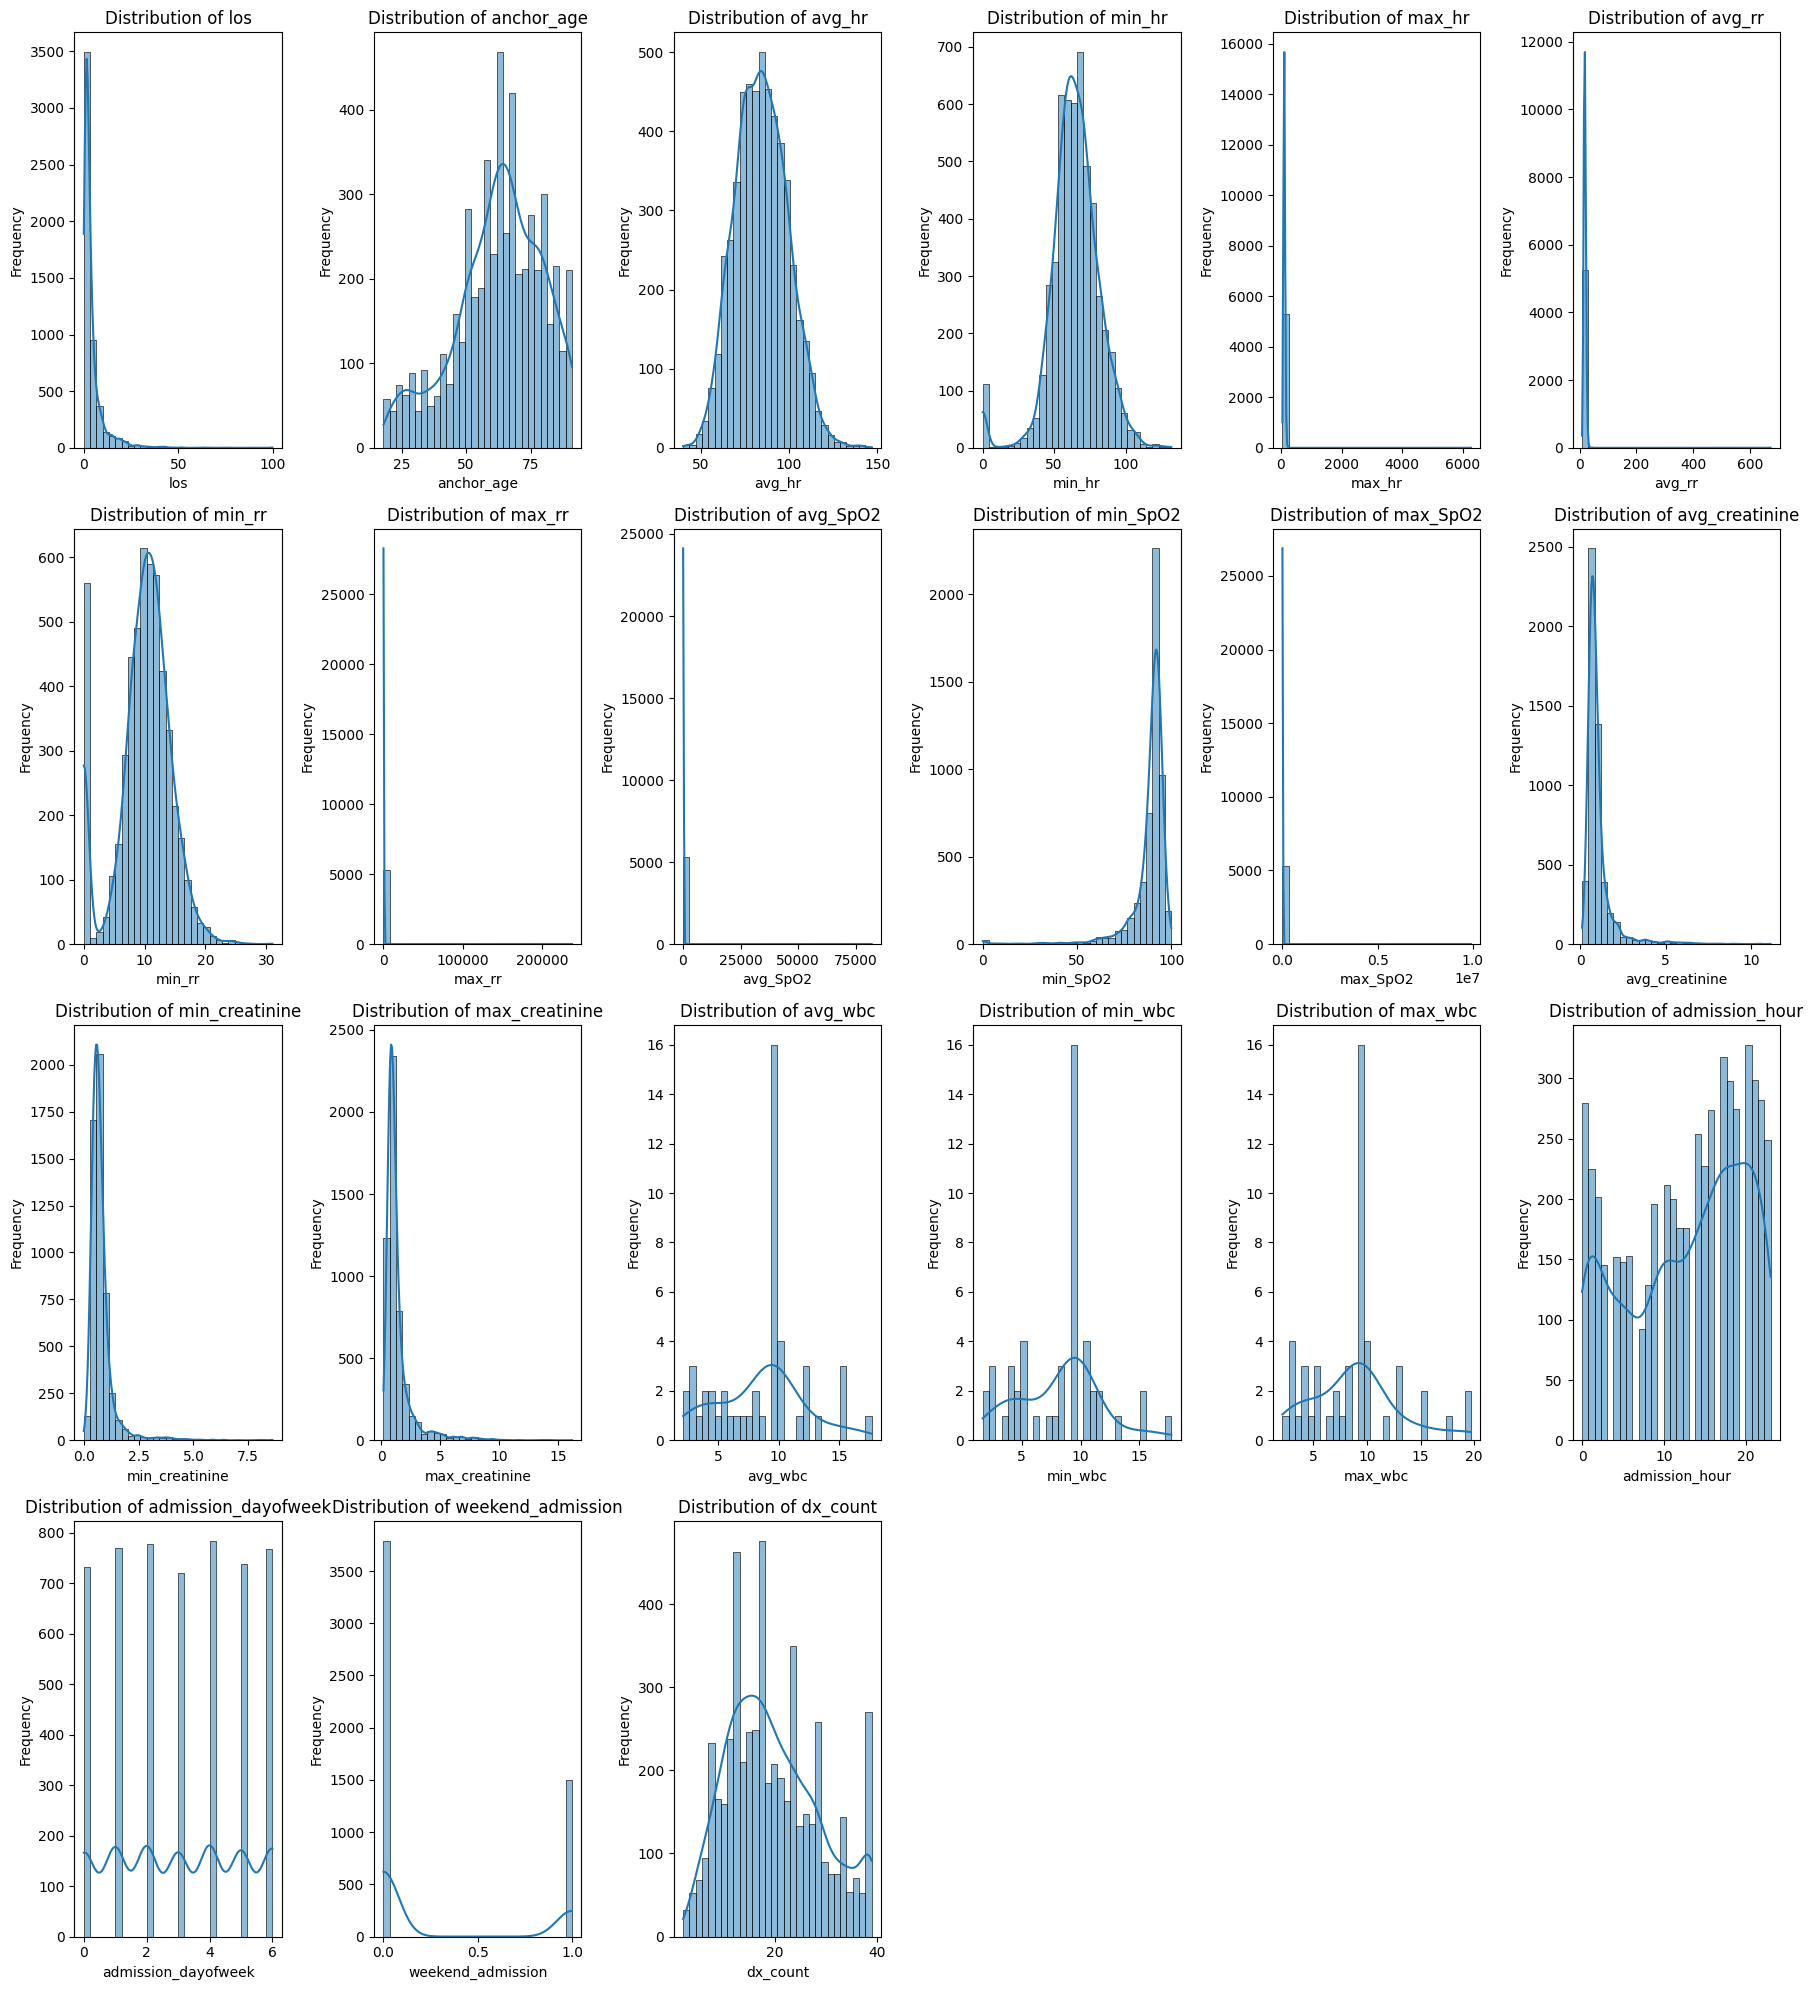

In [26]:
# Get numeric columns (excluding hot-encoded ones)
numeric_columns = mod_icu_sp.select_dtypes(include=['float64', 'int64']).columns

# Set the number of columns per row to 6
n_cols = 6
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  # Calculate the required number of rows

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))

# Flatten axes for easy iteration
axes = axes.flatten()

# Loop through each numeric column and plot its distribution with a histogram
for i, col in enumerate(numeric_columns):
    sns.histplot(icu_sp[col].dropna(), kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide empty subplots (if any)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


Now, for the categorical values, of which we will use countplots:

In [27]:
# Get hot-encoded columns (exclude numeric ones)
hot_encoded_columns = mod_icu_sp.select_dtypes(include=['uint8']).columns

# List of removed columns (no need to apply restriction anymore)
removed_columns = [col for col in hot_encoded_columns if col not in valid_hot_encoded_columns]
print("Removed columns:", removed_columns[:20])

# Set the number of columns per row to 2
n_cols = 2
batch_size = 30  # Number of columns to plot per batch to avoid overloading

# Split the hot_encoded_columns into batches
batches = [hot_encoded_columns[i:i + batch_size] for i in range(0, len(hot_encoded_columns), batch_size)]

# Loop through each batch and create a plot
for batch in batches:
    n_rows = (len(batch) + n_cols - 1) // n_cols  # Calculate the required number of rows

    # Create a grid of subplots for each batch
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Loop through each column in the batch and plot its distribution with a countplot
    for i, col in enumerate(batch):
        sns.countplot(x=mod_icu_sp[col], ax=axes[i])  # Use mod_icu_sp[col] for plotting
        axes[i].set_title(f'Frequency of {col}')
        axes[i].set_xlabel(f'{col} (0 = No, 1 = Yes)')
        axes[i].set_ylabel('Count')

    # Hide empty subplots (if any)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.8, wspace=0.3)  # Increased vertical spacing for clarity

    # Adjust layout to avoid overlap and ensure the titles fit
    plt.tight_layout(pad=4.0)  # Adjust padding

    # Show the plot for the current batch
    plt.show()


Removed columns: []


### Inverse Transform Sampling:

In [28]:
# List of columns with missing values:
cols_with_missing = ['avg_hr', 'min_hr', 'max_hr', 'avg_rr', 'min_rr', 'max_rr', 
                     'avg_SpO2', 'min_SpO2', 'max_SpO2', 'avg_creatinine', 
                     'min_creatinine', 'max_creatinine', 'avg_wbc',
                    'min_wbc', 'max_wbc']

# Loop through columns and fill NaN values using inverse transform sampling
for col in cols_with_missing:
    # Drop NaNs to get the distribution
    data = mod_icu_sp[col].dropna()
    
    # Fit a normal distribution (or use another distribution)
    mu, std = norm.fit(data)
    
    # Number of missing values to fill
    n_missing = mod_icu_sp[col].isna().sum()
    
    # Generate uniform samples
    uniform_samples = np.random.uniform(0, 1, n_missing)
    
    # Generate new values from inverse CDF (ppf)
    new_values = norm.ppf(uniform_samples, loc=mu, scale=std)
    
    # Fill NaNs in the column with generated values
    mod_icu_sp.loc[mod_icu_sp[col].isna(), col] = new_values


In [29]:
#DOUBLE CHECKING: printing all columns with NaN values:
list(mod_icu_sp.columns[mod_icu_sp.isna().any()])

[]

Now, to continue with the Principle Cluster Analysis:

### Normalizing all features:

In [30]:
def normalize(df):
    result = df.copy()
    
    # Select only numeric columns for normalization
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    for feature_name in numeric_columns:
        max_val = df[feature_name].max()
        min_val = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_val) / (max_val - min_val)
        
    return result

# Example usage:
norm_icu_sp = normalize(mod_icu_sp)

# Check the result
print(norm_icu_sp.head())


        los  anchor_age    avg_hr    min_hr    max_hr    avg_rr    min_rr  \
0  0.019608    0.630137  0.626634  0.704545  0.012892  0.016156  0.161290   
1  0.019861    0.794521  0.393110  0.492424  0.010160  0.024618  0.000000   
2  0.019861    0.794521  0.393110  0.492424  0.010160  0.024618  0.000000   
3  0.065998    0.273973  0.452600  0.356061  0.012732  0.024698  0.225806   
4  0.065998    0.273973  0.452600  0.356061  0.012732  0.024698  0.225806   

     max_rr  avg_SpO2  min_SpO2  ...  admission_type_grouped_EMERGENCY  \
0  0.029486  0.012493  0.726097  ...                             False   
1  0.029466  0.012543  0.788846  ...                              True   
2  0.029466  0.012543  0.788846  ...                              True   
3  0.029490  0.012522  0.815739  ...                             False   
4  0.029490  0.012522  0.815739  ...                             False   

   admission_type_grouped_OBSERVATION  admission_type_grouped_SURGICAL  \
0                 

### Performing PCA:

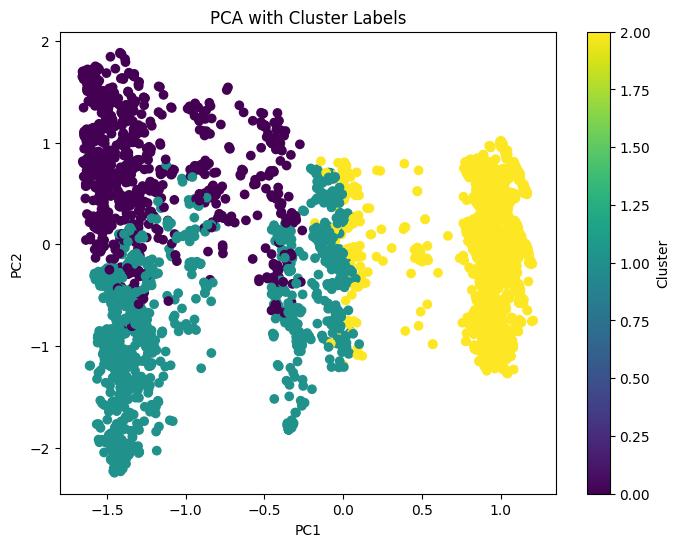

Silhouette Score: 0.539


In [31]:
# Apply KMeans clustering (for example, with 3 clusters)
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(norm_icu_sp)

# Add the cluster labels to the original DataFrame
norm_icu_sp['pca_cluster'] = clusters  # Create a new column 'cluster' with the cluster labels

# Perform PCA on the normalized dataset
pca = PCA(n_components=2)
pca_result_old = pca.fit_transform(norm_icu_sp.drop(columns=['pca_cluster']))  # Exclude the 'cluster' column for PCA

# Create a DataFrame for the PCA results (first two principal components)
pca_df = pd.DataFrame(pca_result_old, columns=['PC1', 'PC2'])

# Plot the first two principal components with colors corresponding to cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=clusters, cmap='viridis')  # Color by cluster
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA with Cluster Labels')
plt.colorbar(label='Cluster')  # Show color bar to map cluster number to colors
plt.show()

#We will use silhouette score to evaluate how well defined our pca clusters are. 
#The closer the value is to one, the better our clusters.

# Silhouette score for cluster evaluation
sil_score_old = silhouette_score(pca_result_old, clusters)
print(f'Silhouette Score: {sil_score_old:.3f}')


Since our silhouette score is not very close to 1, it indicates the clusters are not very distinct, but are still evident in our dataset.

To understand what each cluster could mean, we will find the mean of each cluster per feature, as done below:

In [32]:
#Check the mean of features for each cluster
cluster_means = norm_icu_sp.groupby('pca_cluster').mean()

# Transpose the cluster mean DataFrame for easier viewing
cluster_means = cluster_means.T

# Optionally, to display all columns, set the max_columns to None
pd.set_option('display.max_columns', None)

print(cluster_means)

pca_cluster                                      0         1         2
los                                       0.037171  0.045587  0.041351
anchor_age                                0.631590  0.631567  0.590829
avg_hr                                    0.405609  0.407659  0.424396
min_hr                                    0.488333  0.479696  0.493504
max_hr                                    0.011044  0.011954  0.011442
...                                            ...       ...       ...
admission_location_grouped_OTHER          0.000000  0.005220  0.018150
admission_location_grouped_REFERRAL       1.000000  0.002237  0.001047
admission_location_grouped_SELF-REFERRAL  0.000000  0.038777  0.014311
admission_location_grouped_TRANSFER       0.000000  0.736018  0.000000
admission_location_grouped_UNKNOWN        0.000000  0.001491  0.001396

[420 rows x 3 columns]


We will also check which features contribute to each Principle Component the most:

In [33]:
# 1. Check number of columns in norm_icu_sp and PCA components
print("Number of columns in norm_icu_sp:", norm_icu_sp.shape[1])

# 2. Fit PCA again on the full normalized dataset
pca = PCA(n_components=2)
pca_result_old = pca.fit_transform(norm_icu_sp)

# 3. Create DataFrame for the PCA components matrix
components_df = pd.DataFrame(
    pca.components_,
    columns=norm_icu_sp.columns,
    index=['PC1', 'PC2']
)

print("\nPCA components shape:", pca.components_.shape)
print("PCA components DataFrame shape:", components_df.shape)

# 4. Optional: Show the features with largest absolute influence on each PC
top_features_pc1 = components_df.loc['PC1'].abs().sort_values(ascending=False).head(10)
top_features_pc2 = components_df.loc['PC2'].abs().sort_values(ascending=False).head(10)
print("\nTop contributing features to PC1:\n", top_features_pc1)
print("\nTop contributing features to PC2:\n", top_features_pc2)


Number of columns in norm_icu_sp: 421

PCA components shape: (2, 421)
PCA components DataFrame shape: (2, 421)

Top contributing features to PC1:
 pca_cluster                                   0.587182
admission_location_grouped_EMERGENCY          0.343137
admission_location_EMERGENCY ROOM             0.340557
admission_type_EW EMER.                       0.332892
admission_type_grouped_EMERGENCY              0.314654
admission_location_grouped_REFERRAL           0.231592
admission_location_PHYSICIAN REFERRAL         0.227884
admission_type_grouped_SURGICAL               0.141149
admission_type_SURGICAL SAME DAY ADMISSION    0.141149
admission_location_grouped_TRANSFER           0.109889
Name: PC1, dtype: float64

Top contributing features to PC2:
 admission_location_grouped_TRANSFER           0.404864
admission_location_TRANSFER FROM HOSPITAL     0.386918
admission_type_grouped_URGENT                 0.309945
admission_type_URGENT                         0.309945
admission_location_gr

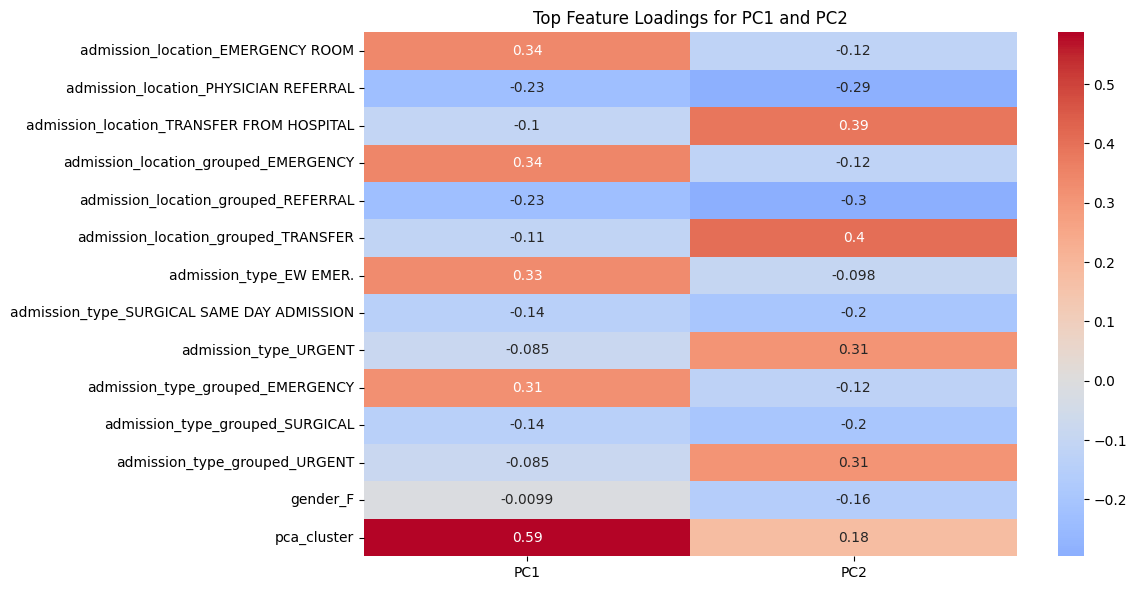

In [34]:
# Get PCA loadings
components_df = pd.DataFrame(pca.components_, columns=norm_icu_sp.columns, index=['PC1', 'PC2'])

# Transpose so we can sort by absolute value
loading_df = components_df.T

# Get top N contributors for each PC
top_n = 10
top_pc1 = loading_df['PC1'].abs().sort_values(ascending=False).head(top_n).index
top_pc2 = loading_df['PC2'].abs().sort_values(ascending=False).head(top_n).index
top_features = top_pc1.union(top_pc2)

# Filter for just those features
top_loadings = loading_df.loc[top_features]

# Plot it
plt.figure(figsize=(12, 6))
sns.heatmap(top_loadings, annot=True, cmap='coolwarm', center=0)
plt.title('Top Feature Loadings for PC1 and PC2')
plt.tight_layout()
plt.show()


## *First column is for Principle Component 1, second for Principle Component 2*

To interpret the heatmap, the values show how much each feature contributes to each Principle Component. Since Principle Components measure the direction of maximum variability.

An easy way to think about this is if you look at a cloud in the sky. Its shape is quite inconsistent. So we can think of the datapoints as a cloud, and the PC's just tell us in which direction (or axis) does the shape of the cloud appear most irregular the most.

In terms of the values of each feature in our heatmap, the greater the absolute value of the value itself, the greater it's influence in determining which direction does the cloud have the most irregular shape.

The negative sign is just saying the feature pulls the shape of the cloud in the opposite direction.



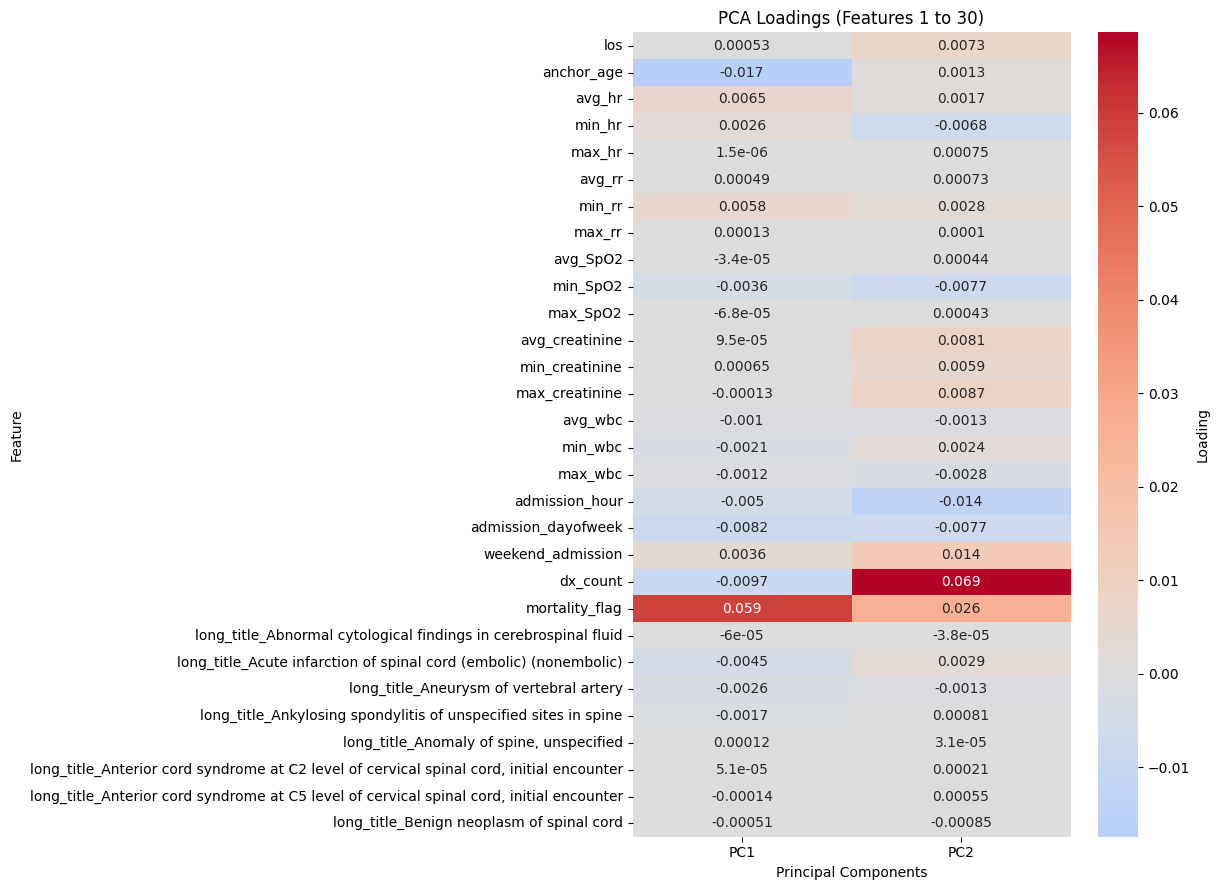

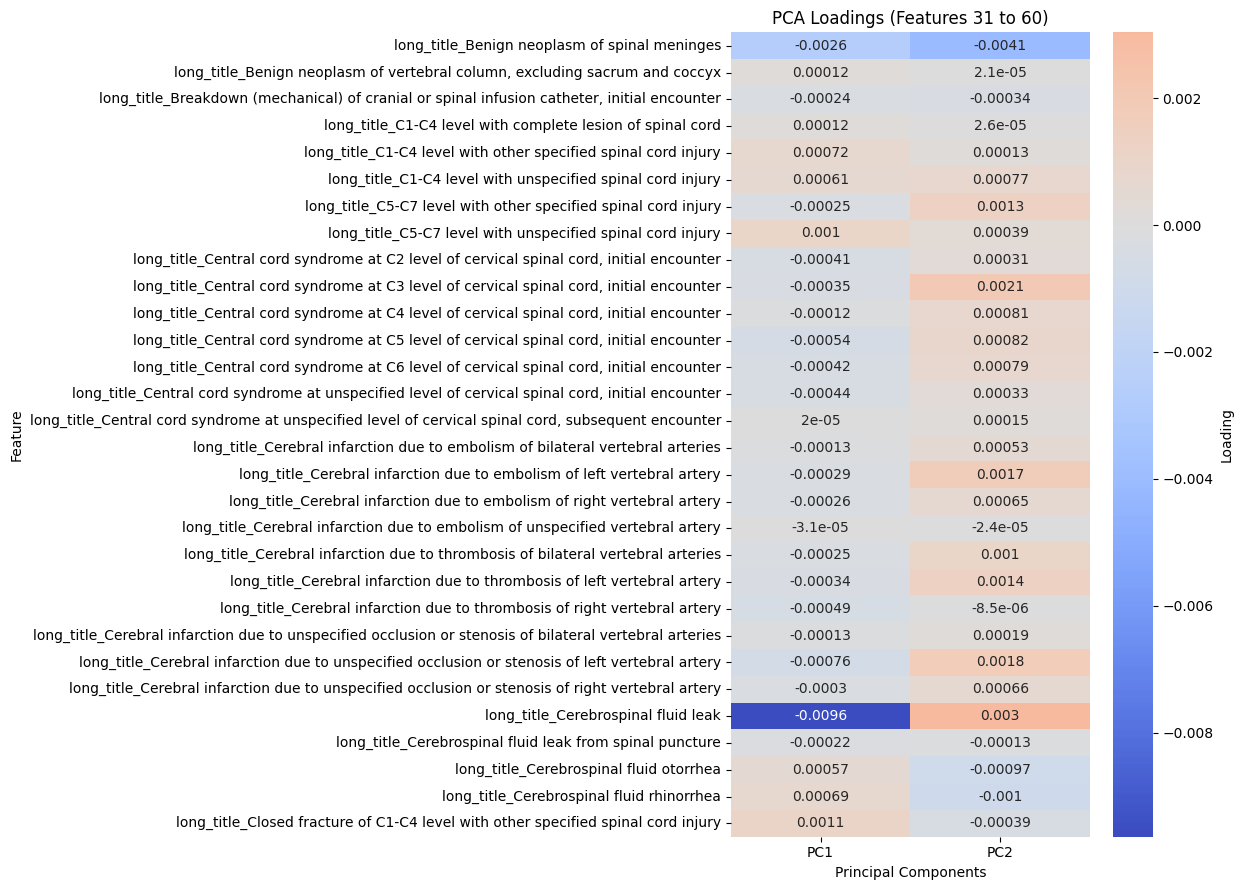

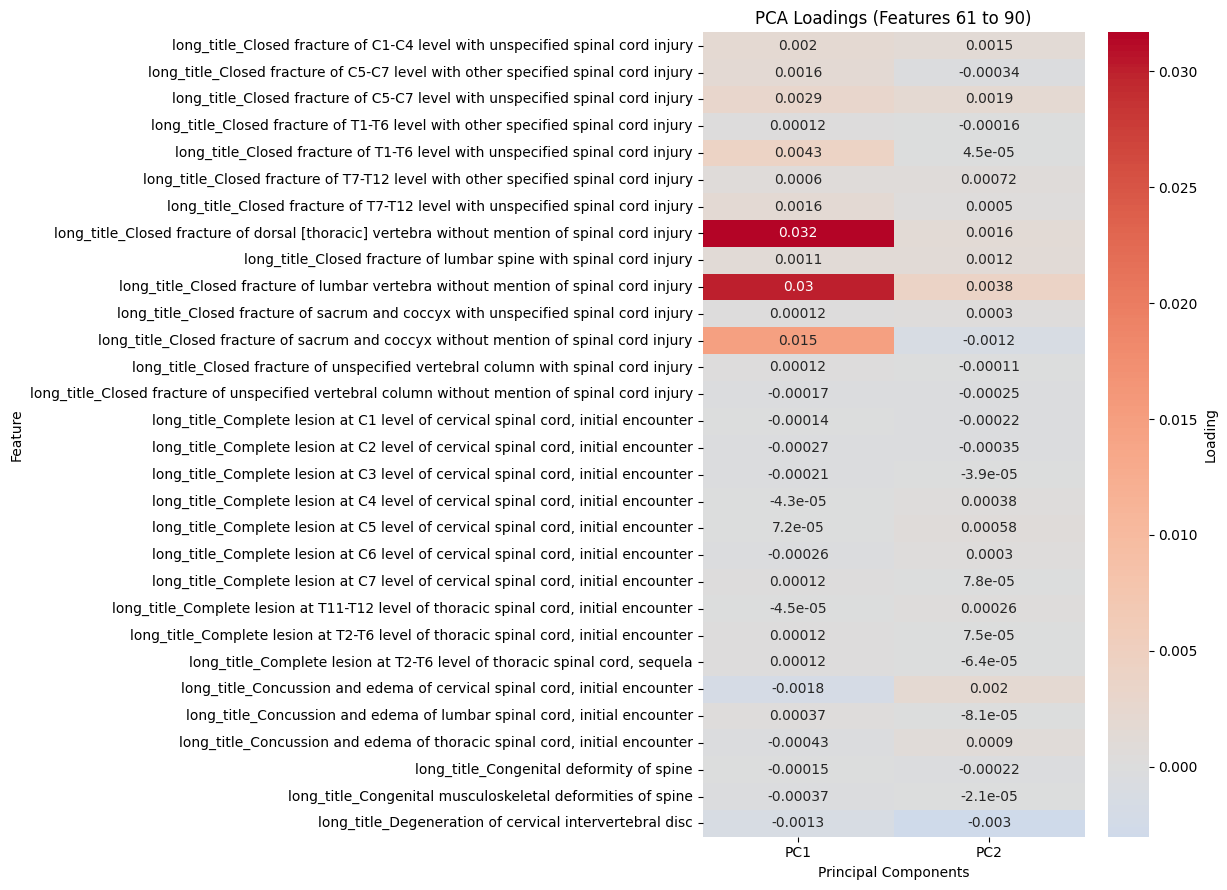

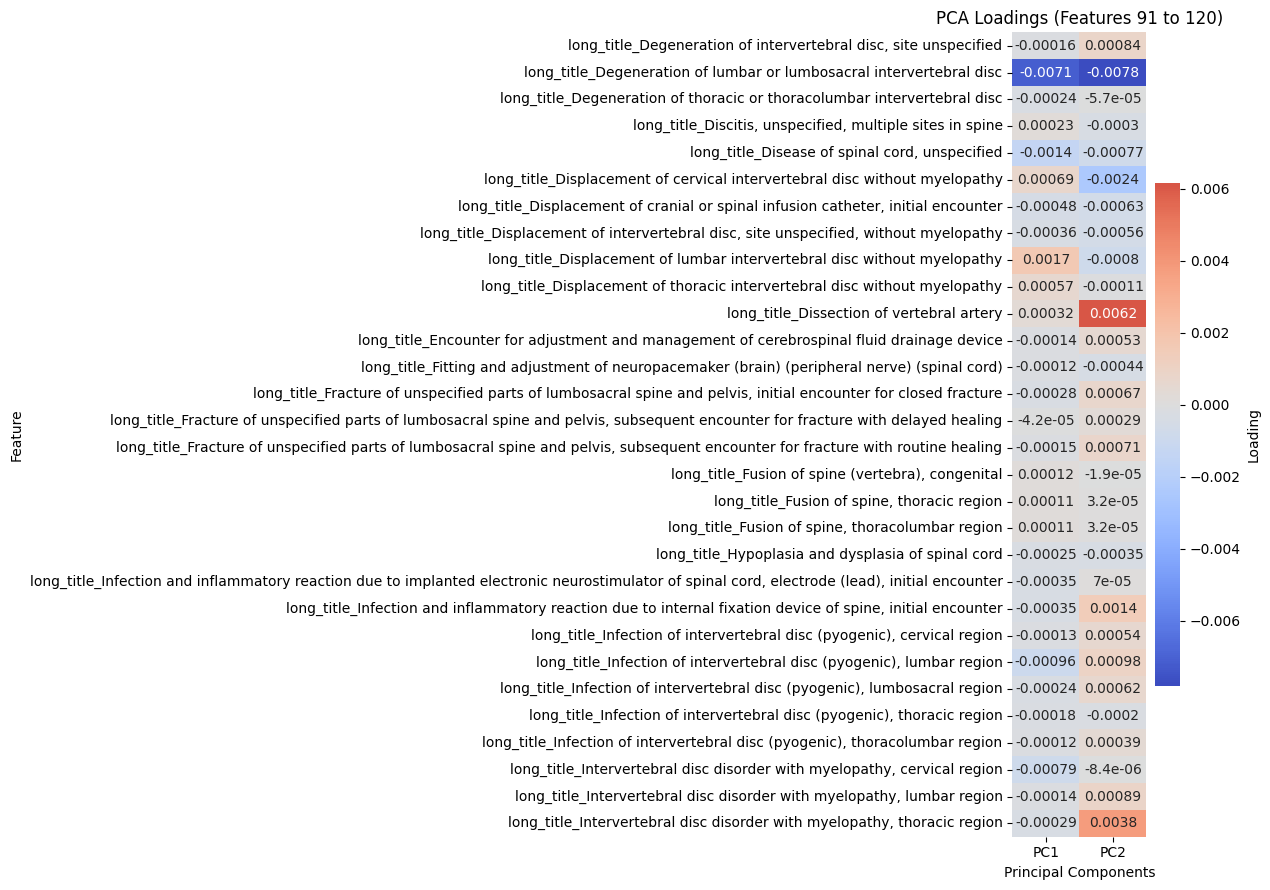

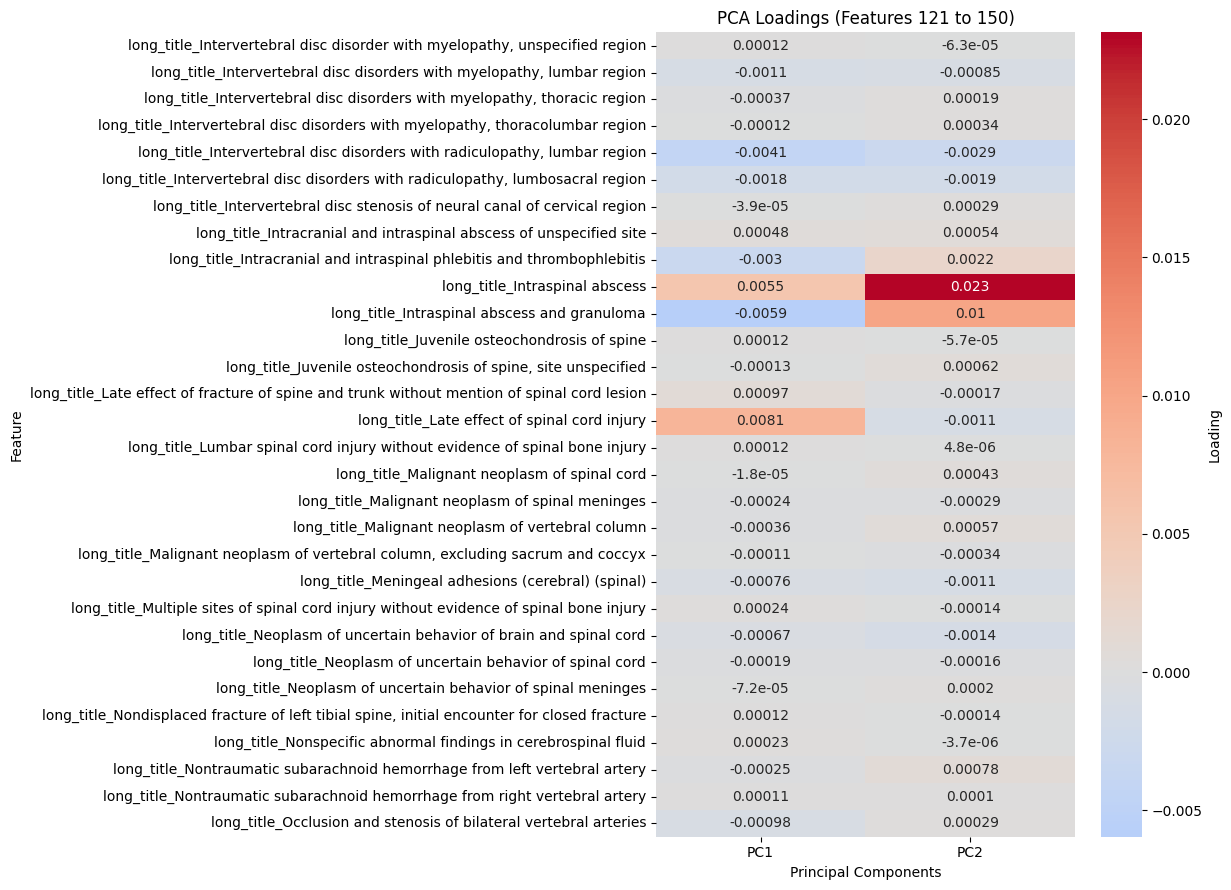

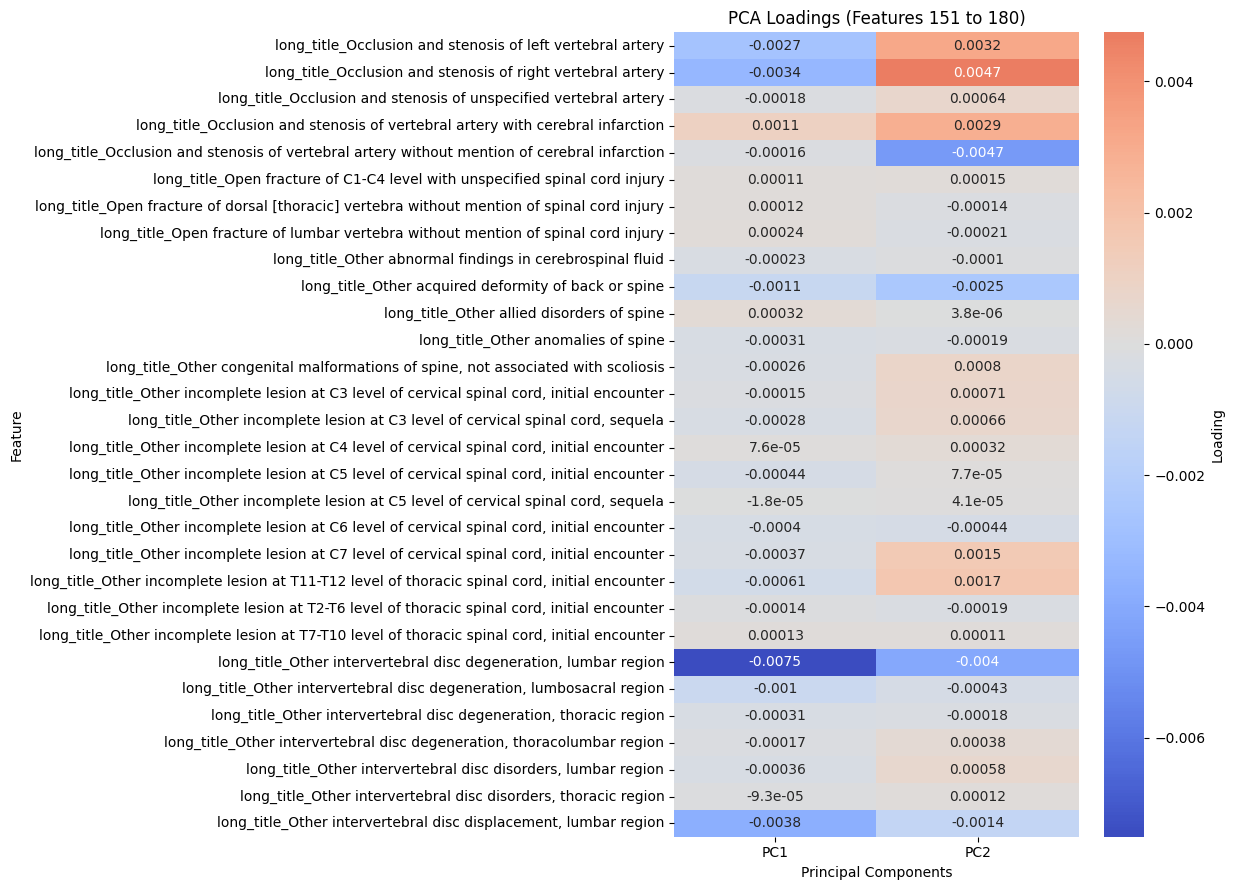

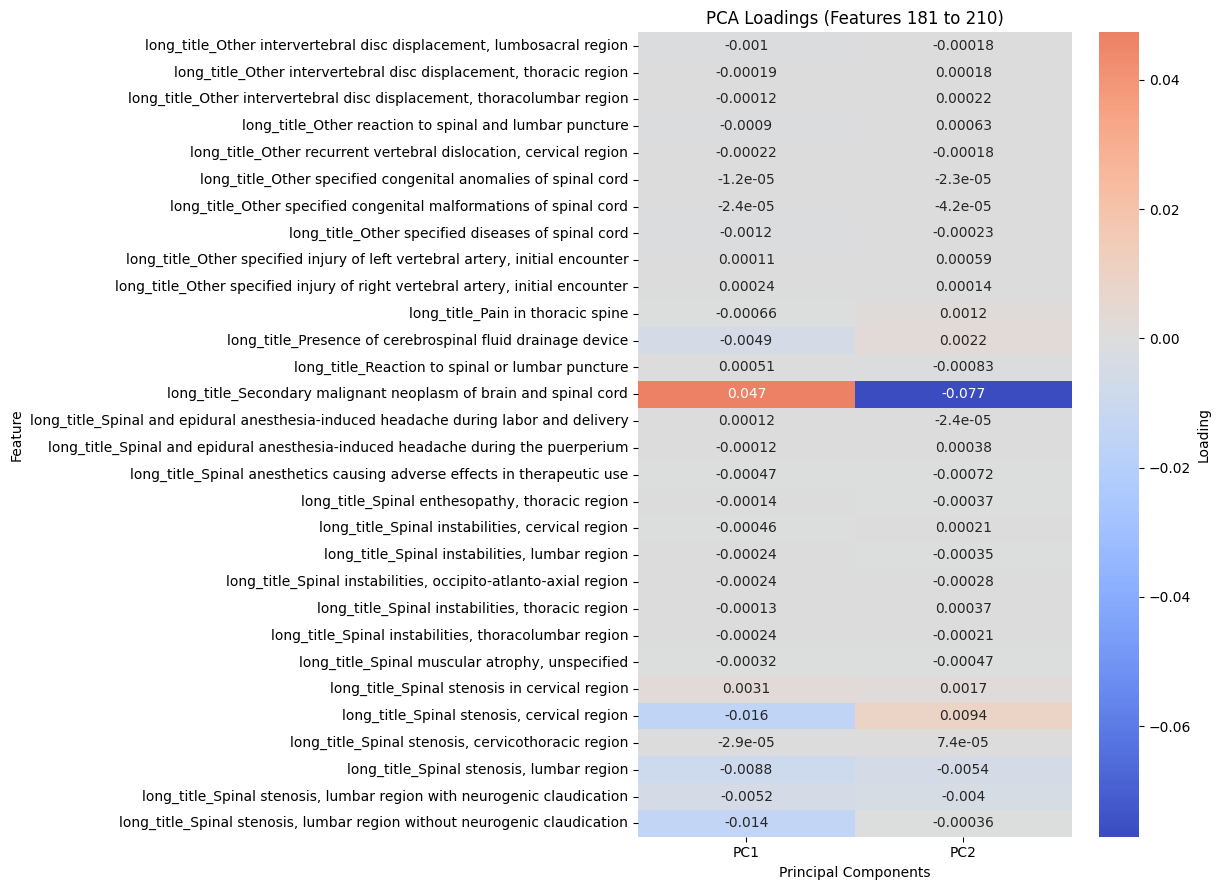

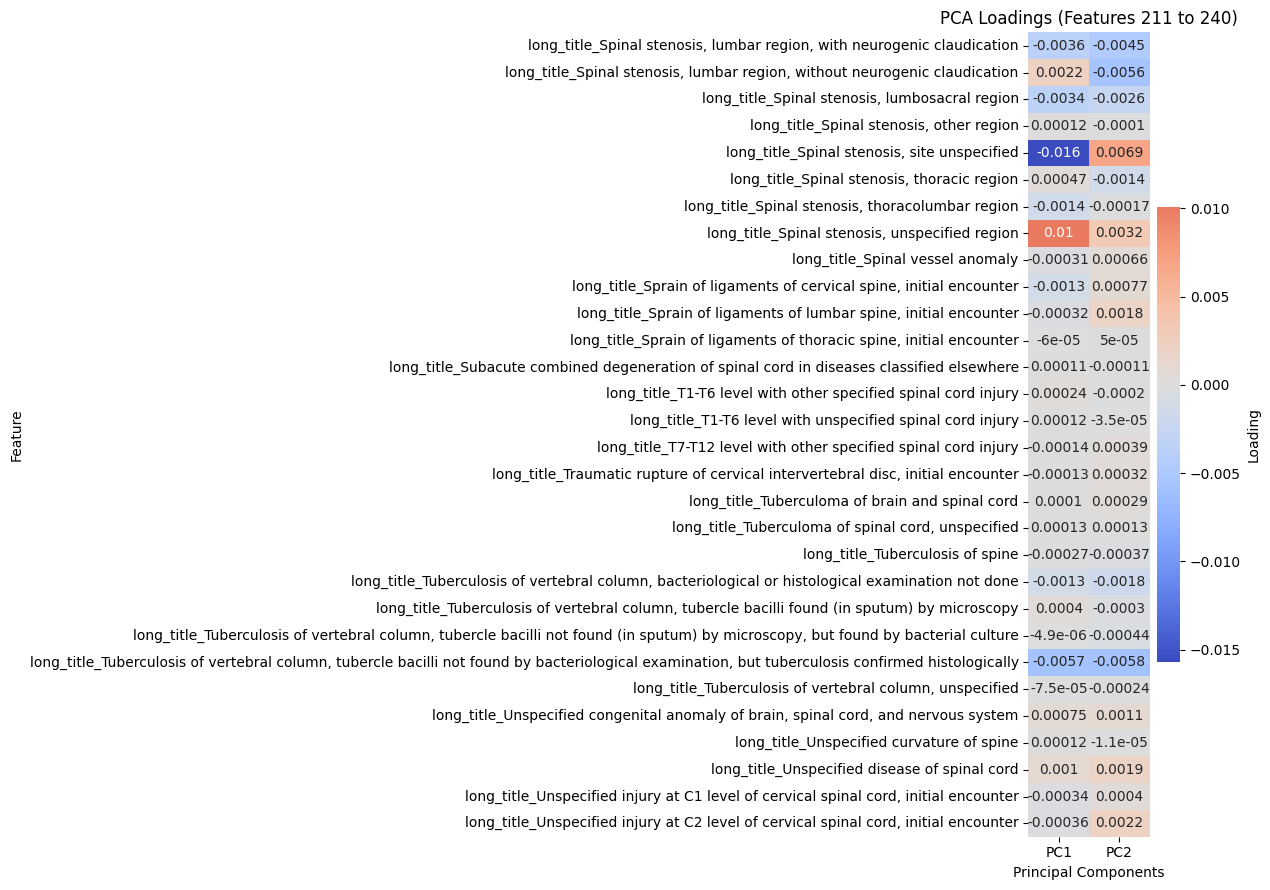

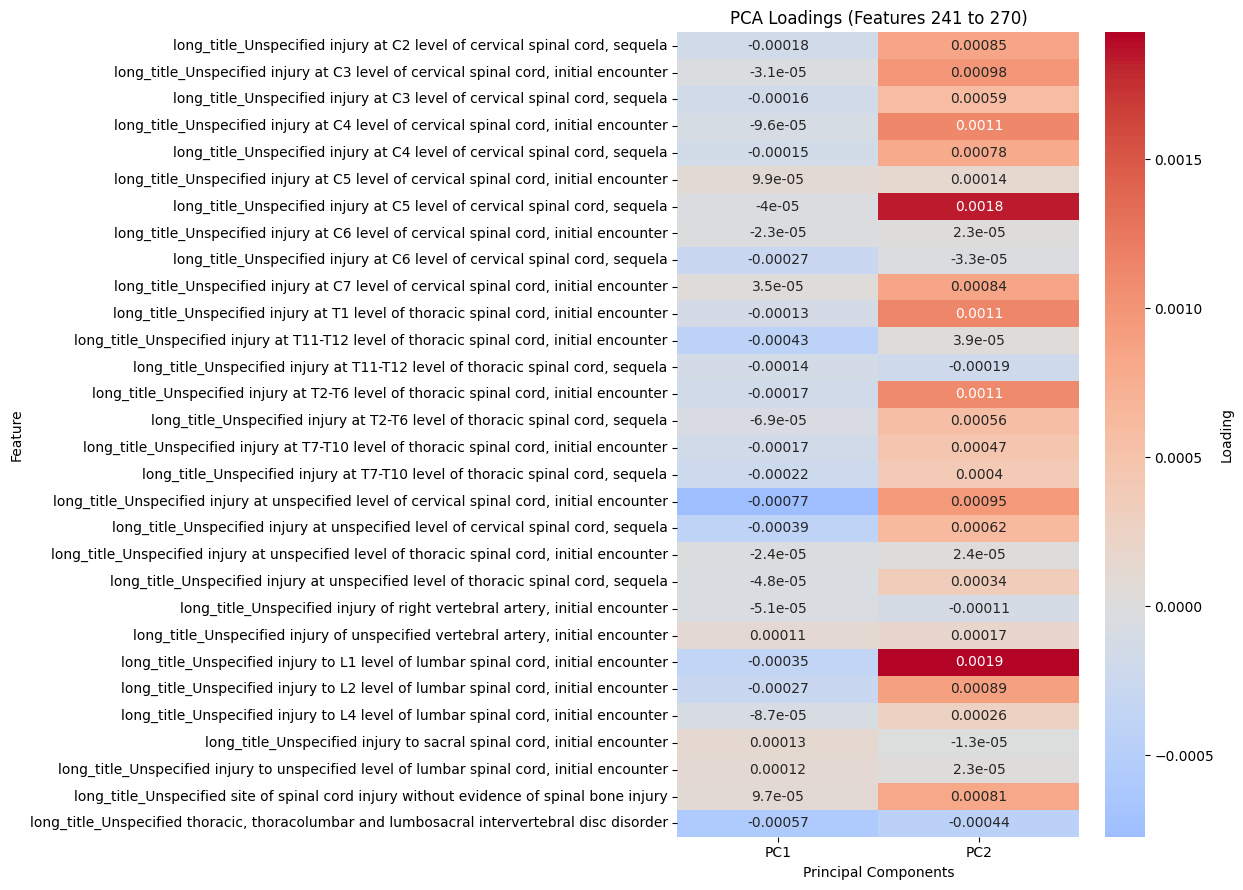

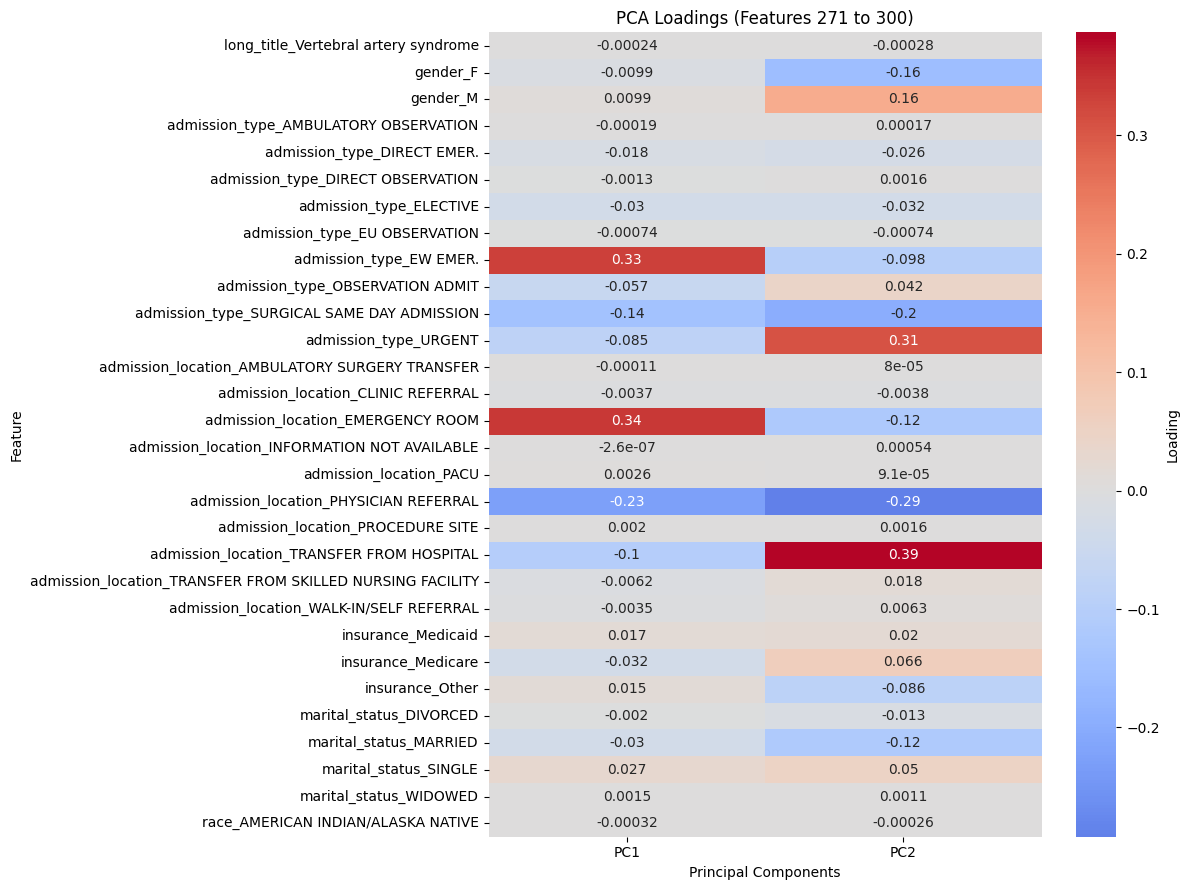

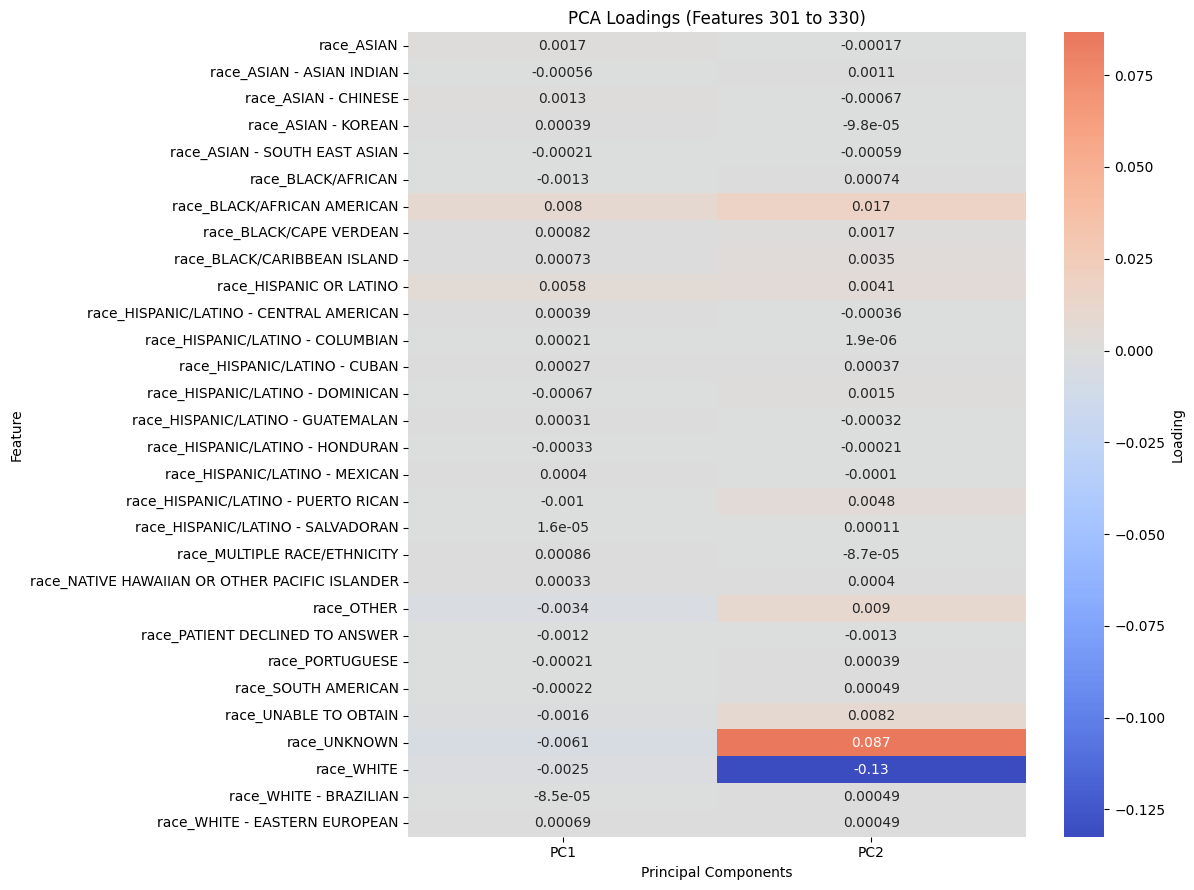

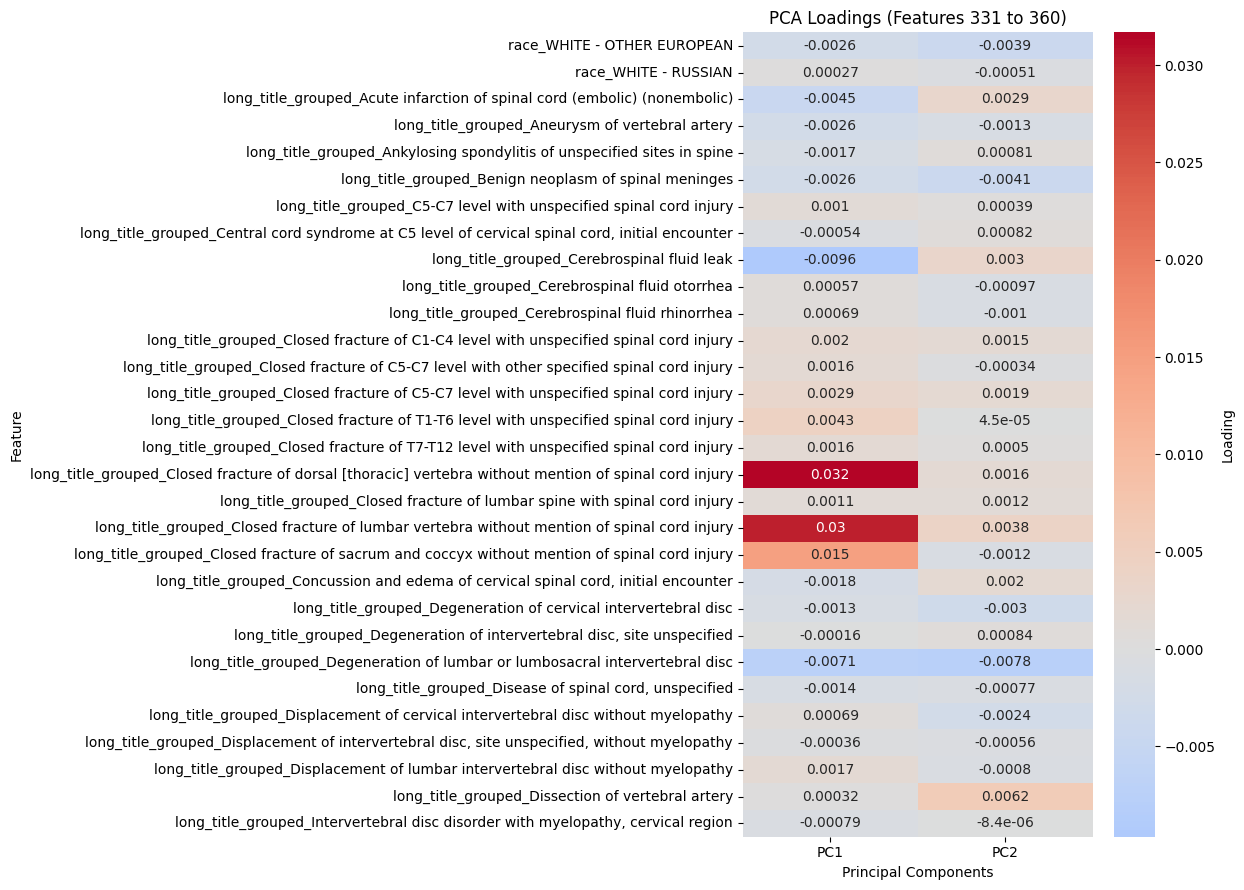

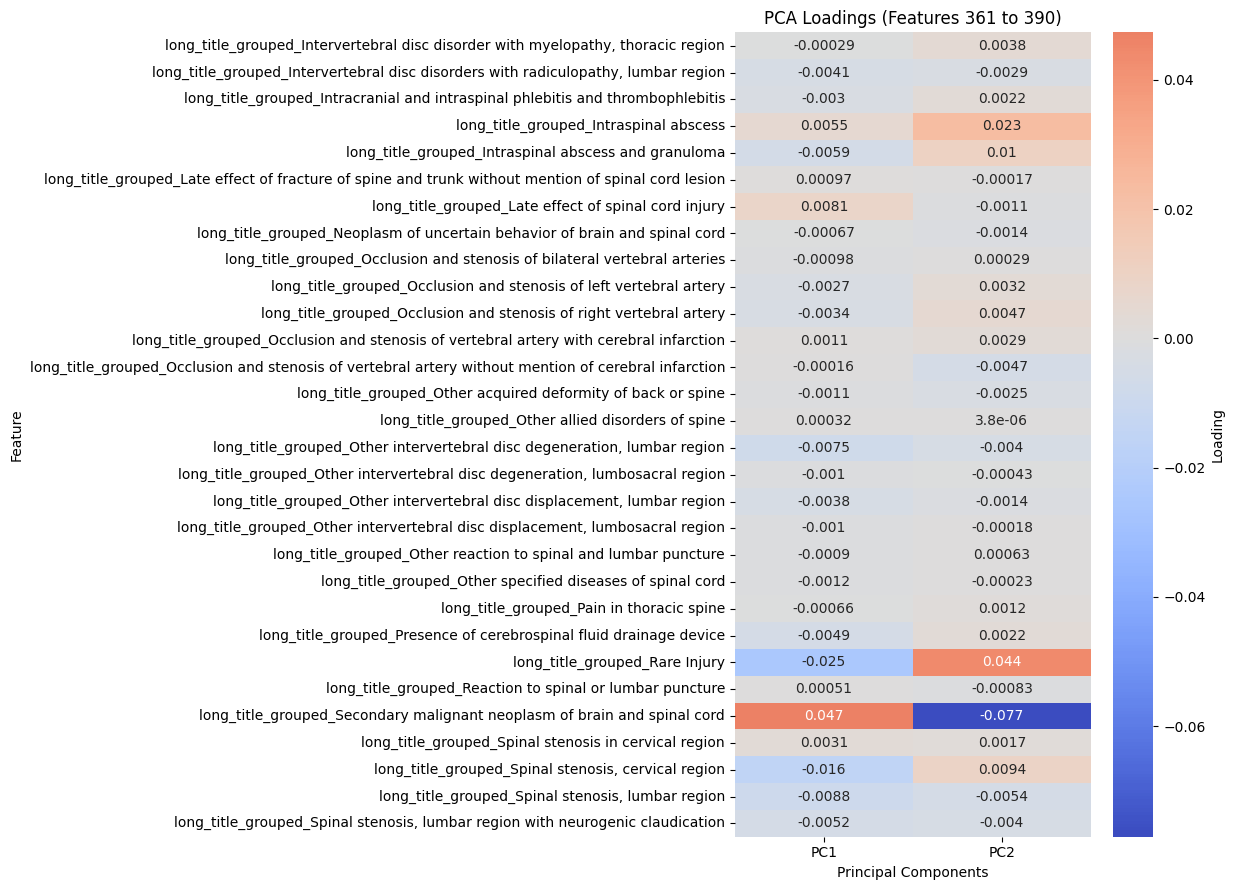

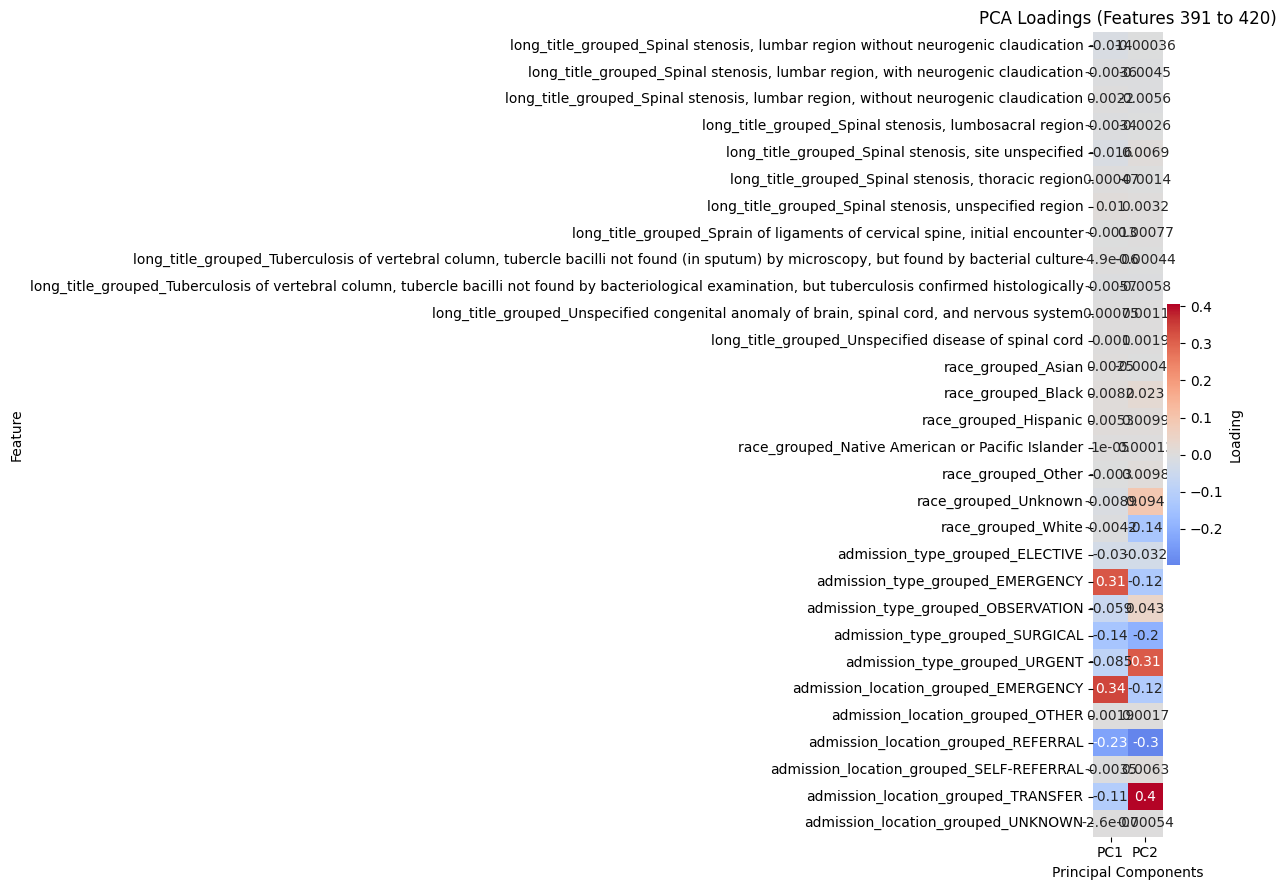

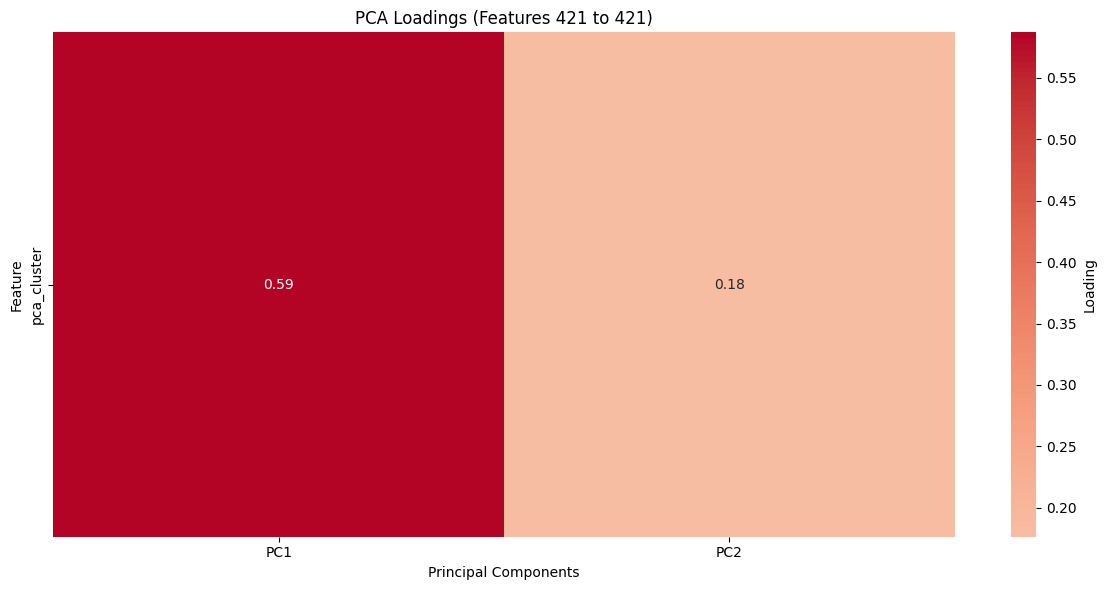

In [35]:
components_df = pd.DataFrame(pca.components_, columns=norm_icu_sp.columns, index=['PC1', 'PC2'])

# Transpose so rows = features, columns = PCs
loading_df = components_df.T

# Number of features per plot chunk
chunk_size = 30
num_features = loading_df.shape[0]
num_chunks = int(np.ceil(num_features / chunk_size))

# Plot each chunk separately
for i in range(num_chunks):
    start = i * chunk_size
    end = min((i + 1) * chunk_size, num_features)
    chunk = loading_df.iloc[start:end]

    plt.figure(figsize=(12, max(6, len(chunk) * 0.3)))
    sns.heatmap(chunk, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Loading'}, 
                xticklabels=['PC1', 'PC2'], yticklabels=chunk.index)
    plt.title(f'PCA Loadings (Features {start+1} to {end})')
    plt.ylabel('Feature')
    plt.xlabel('Principal Components')
    plt.tight_layout()
    plt.show()


So, going back to the plot of the clusters themselves, we will want to focus on clusters that are closer to -1 and 1, as they influence the entire dataset the most.

Using this knowledge and observing the clusters on our plot, it appears that each cluster has sub-clusters.

- Since Emergency Rooms and Emergency admissions appear to pull the data cloud in the positive PC1 direction, they seem to affect the dataset the most in that direction. Consequently, emergency locations also have a strong impact on PC1.
- Physician referrals, transfers from hospital, urgent and same day admissions appear to contribute to PC1 & PC2 direction.
- Male patients tend to pull in the PC2 direction
From this, we can conclude that these are the features that should be certainly included in our machine learning model and pay attention to. 

So the dataset is mostly influenced by male patients, emergencies, surgical admissions, physician referrals, urgent and same day admissions.

From our earlier plots, because we observe length of stay is NOT normally distributed, we will apply a test that will help determine if the clusters affect Length of Stay.

We will use the Kruskal Wallis test, which determines if the distribution of length of stay for each cluster differs.

In [36]:
# Group LOS values by cluster
cluster_los_groups = [norm_icu_sp[norm_icu_sp['pca_cluster'] == i]['los'] for i in range(3)]  # Adjust number of clusters accordingly

# Perform Kruskal-Wallis test
h_stat, p_value = kruskal(*cluster_los_groups)
print(f"Kruskal-Wallis test result: H-statistic = {h_stat}, p-value = {p_value}")

# Check if p-value is below a threshold (typically 0.05) to conclude that the clusters affect LOS
if p_value < 0.05:
    print("The clusters significantly affect LOS.")
else:
    print("No significant difference in LOS between clusters.")


Kruskal-Wallis test result: H-statistic = 30.100903515140836, p-value = 2.908518640692144e-07
The clusters significantly affect LOS.


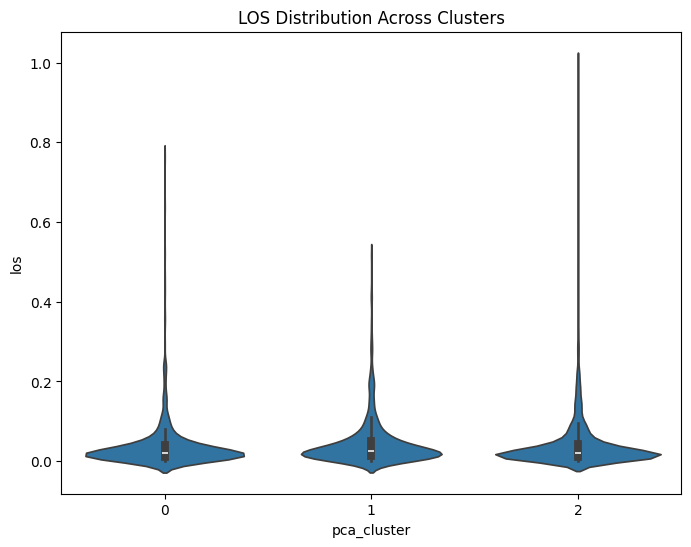

In [37]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='pca_cluster', y='los', data=norm_icu_sp)
plt.title('LOS Distribution Across Clusters')
plt.show()


From our violin plot, we do observe that cluster 2 appears to have the greatest length of stay, while cluster 0 has the least, however this is due to the outliers in the clusters. This could also be a result of our inverse transform sampling, which  created new datapoints for all numerical NaN value columns

The quartiles of cluster 1 also seem to be bulbed while more streamline for cluster 2 and thin for cluster 0, further indicating potential skew because of our data processing earlier.

The overall distributions appear to look quite similar, but getting wider as we progress from cluster 0 to 2, further evidence of the potential skew.






We can attempt to determine that length of stay is directly influenced by individual or a smaller combination of features, as our clusters for PCA seem to have a quantifiable impact on los, but this impact is not massive at first glance. 

We will double check by excluding the wbc columns, as inverse transform sampling had the greatest affect on these features due to there being more than 5000 NaN values.


First, checking the violin plots of average, minimum, and maximum white blood cell count per cluster:

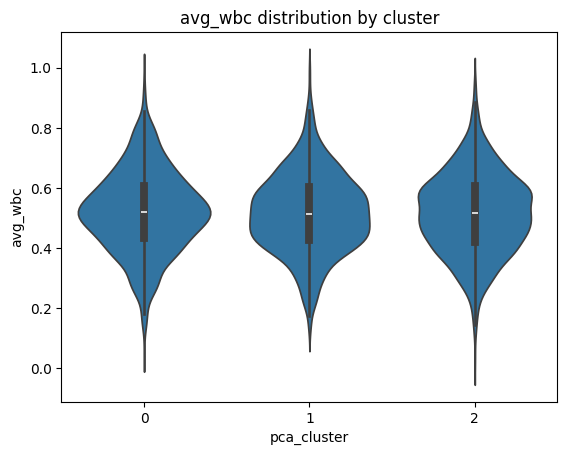

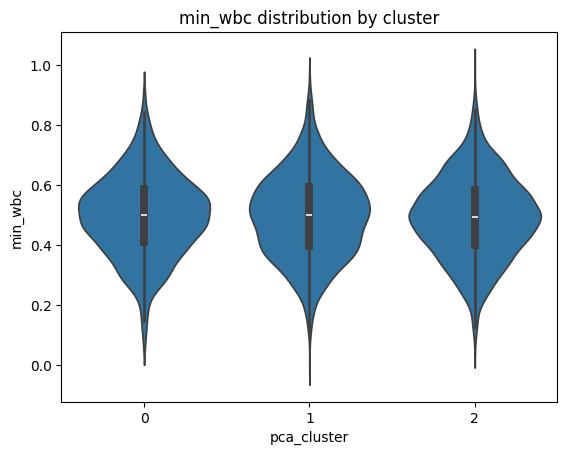

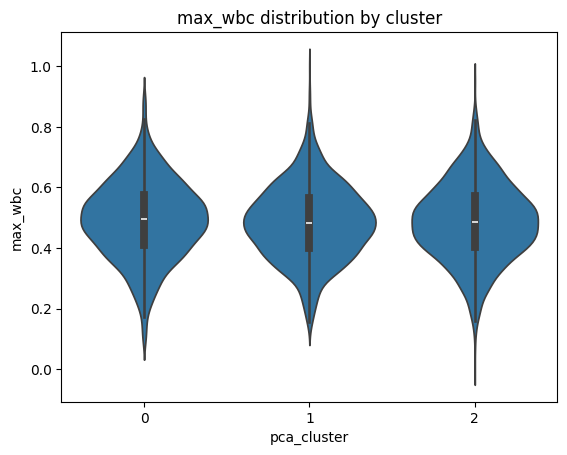

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in ['avg_wbc', 'min_wbc', 'max_wbc']:
    sns.violinplot(x='pca_cluster', y=feature, data=norm_icu_sp)
    plt.title(f'{feature} distribution by cluster')
    plt.show()


It appears that the distributions are near identical with exceptions to outliers in the clusters, which is a result of the wbc features having a great amount of missing values that were filled in using inverse transform sampling

Now, redoing our PCA without wbc features:

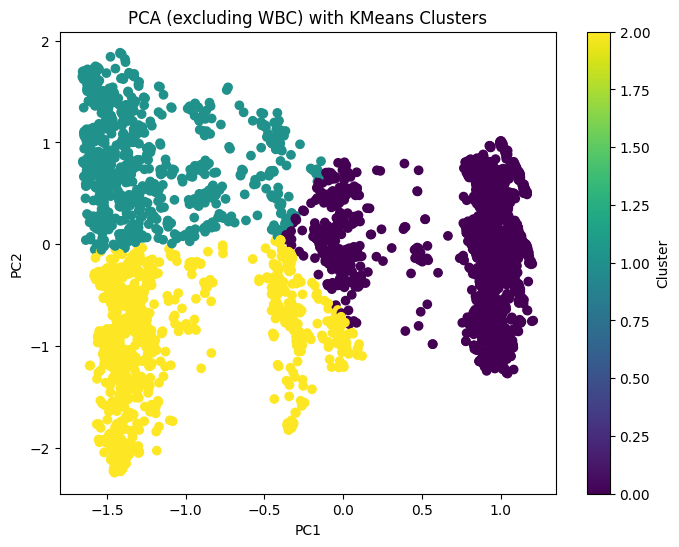

Silhouette Score: 0.593


In [39]:
# Drop WBC-related features and the old cluster label
reduced_features = norm_icu_sp.drop(columns=['avg_wbc', 'min_wbc', 'max_wbc', 'pca_cluster'])

# Re-run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(reduced_features)

# Apply KMeans on reduced PCA result
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_result)

# Add new cluster labels
norm_icu_sp['new_cluster'] = clusters

# Visualize PCA with new clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA (excluding WBC) with KMeans Clusters')
plt.colorbar(label='Cluster')
plt.show()

# Silhouette score for cluster evaluation
sil_score = silhouette_score(pca_result, clusters)
print(f'Silhouette Score: {sil_score:.3f}')


Our silhouette score is much closer than before, indicating slightly more prominent clusters

Again, we will compute the contributions of each feature to each component, as well as the top contributions per principle cluster.

C:\Users\Shrivar\AppData\Local\Temp\ipykernel_26552\1375546663.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='new_cluster', y='los', data=norm_icu_sp, palette='Set2')


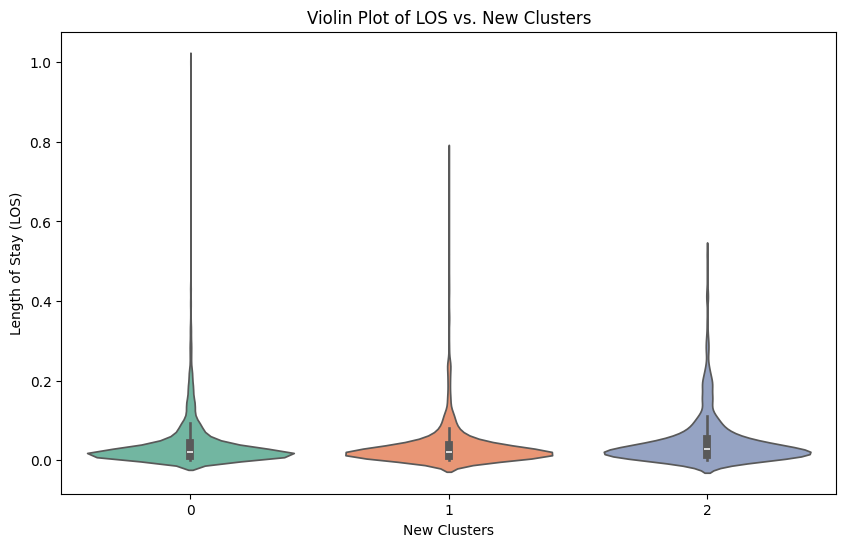

In [40]:
# Create a violin plot for LOS vs. New Clusters
plt.figure(figsize=(10, 6))
sns.violinplot(x='new_cluster', y='los', data=norm_icu_sp, palette='Set2')
plt.title('Violin Plot of LOS vs. New Clusters')
plt.xlabel('New Clusters')
plt.ylabel('Length of Stay (LOS)')
plt.show()

In [41]:
# Get the loadings (contributions of each feature to the components)
pca_components = pca.components_

# Create a DataFrame for better readability
pca_features = pd.DataFrame(pca_components, columns=reduced_features.columns, index=[f"PC{i+1}" for i in range(pca_components.shape[0])])

# Display the contributions of each feature to the PCs
print(pca_features)


          los  anchor_age    avg_hr    min_hr    max_hr    avg_rr    min_rr  \
PC1  0.000121   -0.024013  0.007703  0.003453 -0.000080  0.000486  0.005351   
PC2 -0.009502    0.065639 -0.006808  0.003287 -0.000932 -0.000611  0.008669   

       max_rr  avg_SpO2  min_SpO2  max_SpO2  avg_creatinine  min_creatinine  \
PC1  0.000156 -0.000094 -0.003859 -0.000142       -0.000329        0.000516   
PC2 -0.000373 -0.000466  0.006027 -0.000387       -0.006252       -0.004843   

     max_creatinine  admission_hour  admission_dayofweek  weekend_admission  \
PC1       -0.000585       -0.005886            -0.008444           0.004791   
PC2       -0.007020        0.017028             0.007756          -0.022760   

     dx_count  mortality_flag  \
PC1 -0.017300        0.071068   
PC2 -0.042676        0.041637   

     long_title_Abnormal cytological findings in cerebrospinal fluid  \
PC1                                          -0.000028                 
PC2                                       

In [42]:
# 1. Drop WBC-related features and the old cluster label
reduced_features = norm_icu_sp.drop(columns=['avg_wbc', 'min_wbc', 'max_wbc', 'pca_cluster'])

# 2. Fit PCA on the reduced dataset (excluding WBC features)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(reduced_features)

# 3. Create DataFrame for the PCA components matrix (for reduced dataset)
components_df_reduced = pd.DataFrame(
    pca.components_,
    columns=reduced_features.columns,
    index=['PC1', 'PC2']
)

# 4. Optional: Show the features with the largest absolute influence on each PC (reduced dataset)
top_features_pc1_reduced = components_df_reduced.loc['PC1'].abs().sort_values(ascending=False).head(10)
top_features_pc2_reduced = components_df_reduced.loc['PC2'].abs().sort_values(ascending=False).head(10)

print("\nTop contributing features to PC1 (reduced dataset):\n", top_features_pc1_reduced)
print("\nTop contributing features to PC2 (reduced dataset):\n", top_features_pc2_reduced)



Top contributing features to PC1 (reduced dataset):
 new_cluster                                  0.590373
admission_location_grouped_EMERGENCY         0.352214
admission_location_EMERGENCY ROOM            0.349711
admission_type_EW EMER.                      0.320615
admission_type_grouped_EMERGENCY             0.310600
admission_location_grouped_TRANSFER          0.203270
admission_location_TRANSFER FROM HOSPITAL    0.193088
admission_type_URGENT                        0.149913
admission_type_grouped_URGENT                0.149913
admission_location_grouped_REFERRAL          0.143031
Name: PC1, dtype: float64

Top contributing features to PC2 (reduced dataset):
 admission_location_grouped_REFERRAL           0.372950
admission_location_PHYSICIAN REFERRAL         0.369194
admission_location_grouped_TRANSFER           0.273423
admission_location_TRANSFER FROM HOSPITAL     0.263114
admission_type_SURGICAL SAME DAY ADMISSION    0.260933
admission_type_grouped_SURGICAL               0.260

In [43]:
#Check the mean of features for each cluster
cluster_means_new = norm_icu_sp.groupby('new_cluster').mean()

# Transpose the cluster mean DataFrame for easier viewing

cluster_means_new = reduced_features.groupby('new_cluster').mean()
cluster_means_new = cluster_means_new.T

# Optionally, to display all columns, set the max_columns to None
pd.set_option('display.max_columns', None)

print(cluster_means_new)

# Print the top 10 features (by mean) for each cluster
for cluster in cluster_means_new.columns:
    print(f"\nTop 10 features for cluster {cluster}:")
    top_features = cluster_means_new[cluster].sort_values(ascending=False).head(10)
    print(top_features)




new_cluster                                      0         1         2
los                                       0.040671  0.036746  0.048566
anchor_age                                0.597085  0.648001  0.607549
avg_hr                                    0.421646  0.402714  0.414366
min_hr                                    0.491893  0.487038  0.482623
max_hr                                    0.011364  0.010925  0.012369
...                                            ...       ...       ...
admission_location_grouped_OTHER          0.015791  0.001889  0.007092
admission_location_grouped_REFERRAL       0.002256  0.928234  0.088652
admission_location_grouped_SELF-REFERRAL  0.011602  0.021719  0.030142
admission_location_grouped_TRANSFER       0.005156  0.038716  0.824468
admission_location_grouped_UNKNOWN        0.000967  0.000000  0.002660

[417 rows x 3 columns]

Top 10 features for cluster 0:
admission_location_grouped_EMERGENCY    0.964228
admission_location_EMERGENCY ROOM       0.9

Looking at our new results, the top features contributing to each PC remain the same, however with stronger contributions. So we will need to pay special attention to white, male patients in emergencies, particularly those who are under urgent, same day admissions. These patients also appear to be older, around 50-60 years old(based on anchor age) have a slightly low min_SpO2 (blood oxygen levels) across all clusters (should be 0.95 to 1.00), which could indicate respiratory complications.

Cluster 0: Characterized by patients who are primarily referred through physician referrals or other referrals, with a focus on surgical admissions, predominantly married individuals.

Cluster 1: Consists mainly of patients admitted through emergency rooms, with a focus on emergency admissions.

Cluster 2: Primarily transferred from hospitals, with urgent admission types, and higher diagnosis counts.

However, the issue still remains that each cluster seem to have overall, similar distributions for length of stay. Considering this, we will attempt to perform clustering with PCA via direct pair comparisons to obtain more consistent results.

# Trying clustering without PCA:

As per our correlation matrix, we will now focus on features that are correlated with length of stay and try to observe clusters with these features.


## Using the Elbow Method to find the best k:

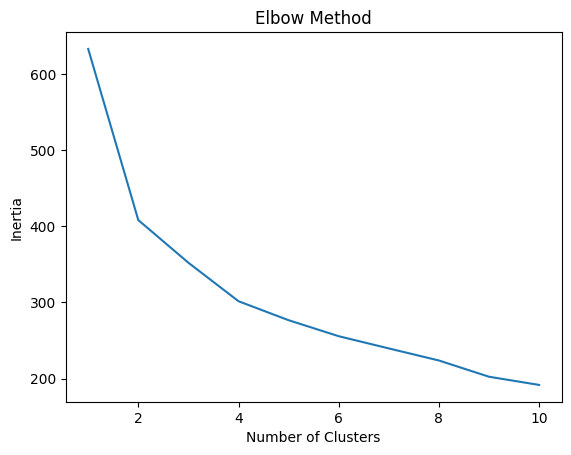

In [44]:
# Select the relevant columns
focus_features = ['dx_count', 
                  'max_creatinine', 'min_creatinine', 'min_SpO2',
                  'min_rr', 'avg_rr', 'max_rr', 
                  'min_hr', 'max_hr']

X = norm_icu_sp[focus_features]

# Elbow method to choose the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()



We observe K=2 is most optimal.

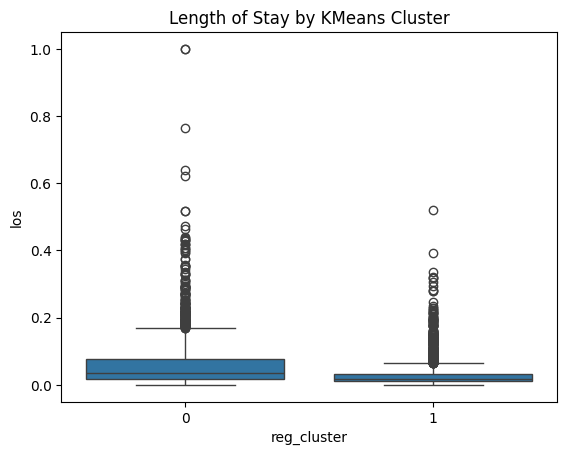

In [45]:
# Fit KMeans with a chosen number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=2, random_state=42)
norm_icu_sp['reg_cluster'] = kmeans.fit_predict(X)

# Visualize Length of Stay (LOS) by Cluster
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=norm_icu_sp, x='reg_cluster', y='los')
plt.title('Length of Stay by KMeans Cluster')
plt.show()

So this means that cluster 1 tended to have much longer length of stay.

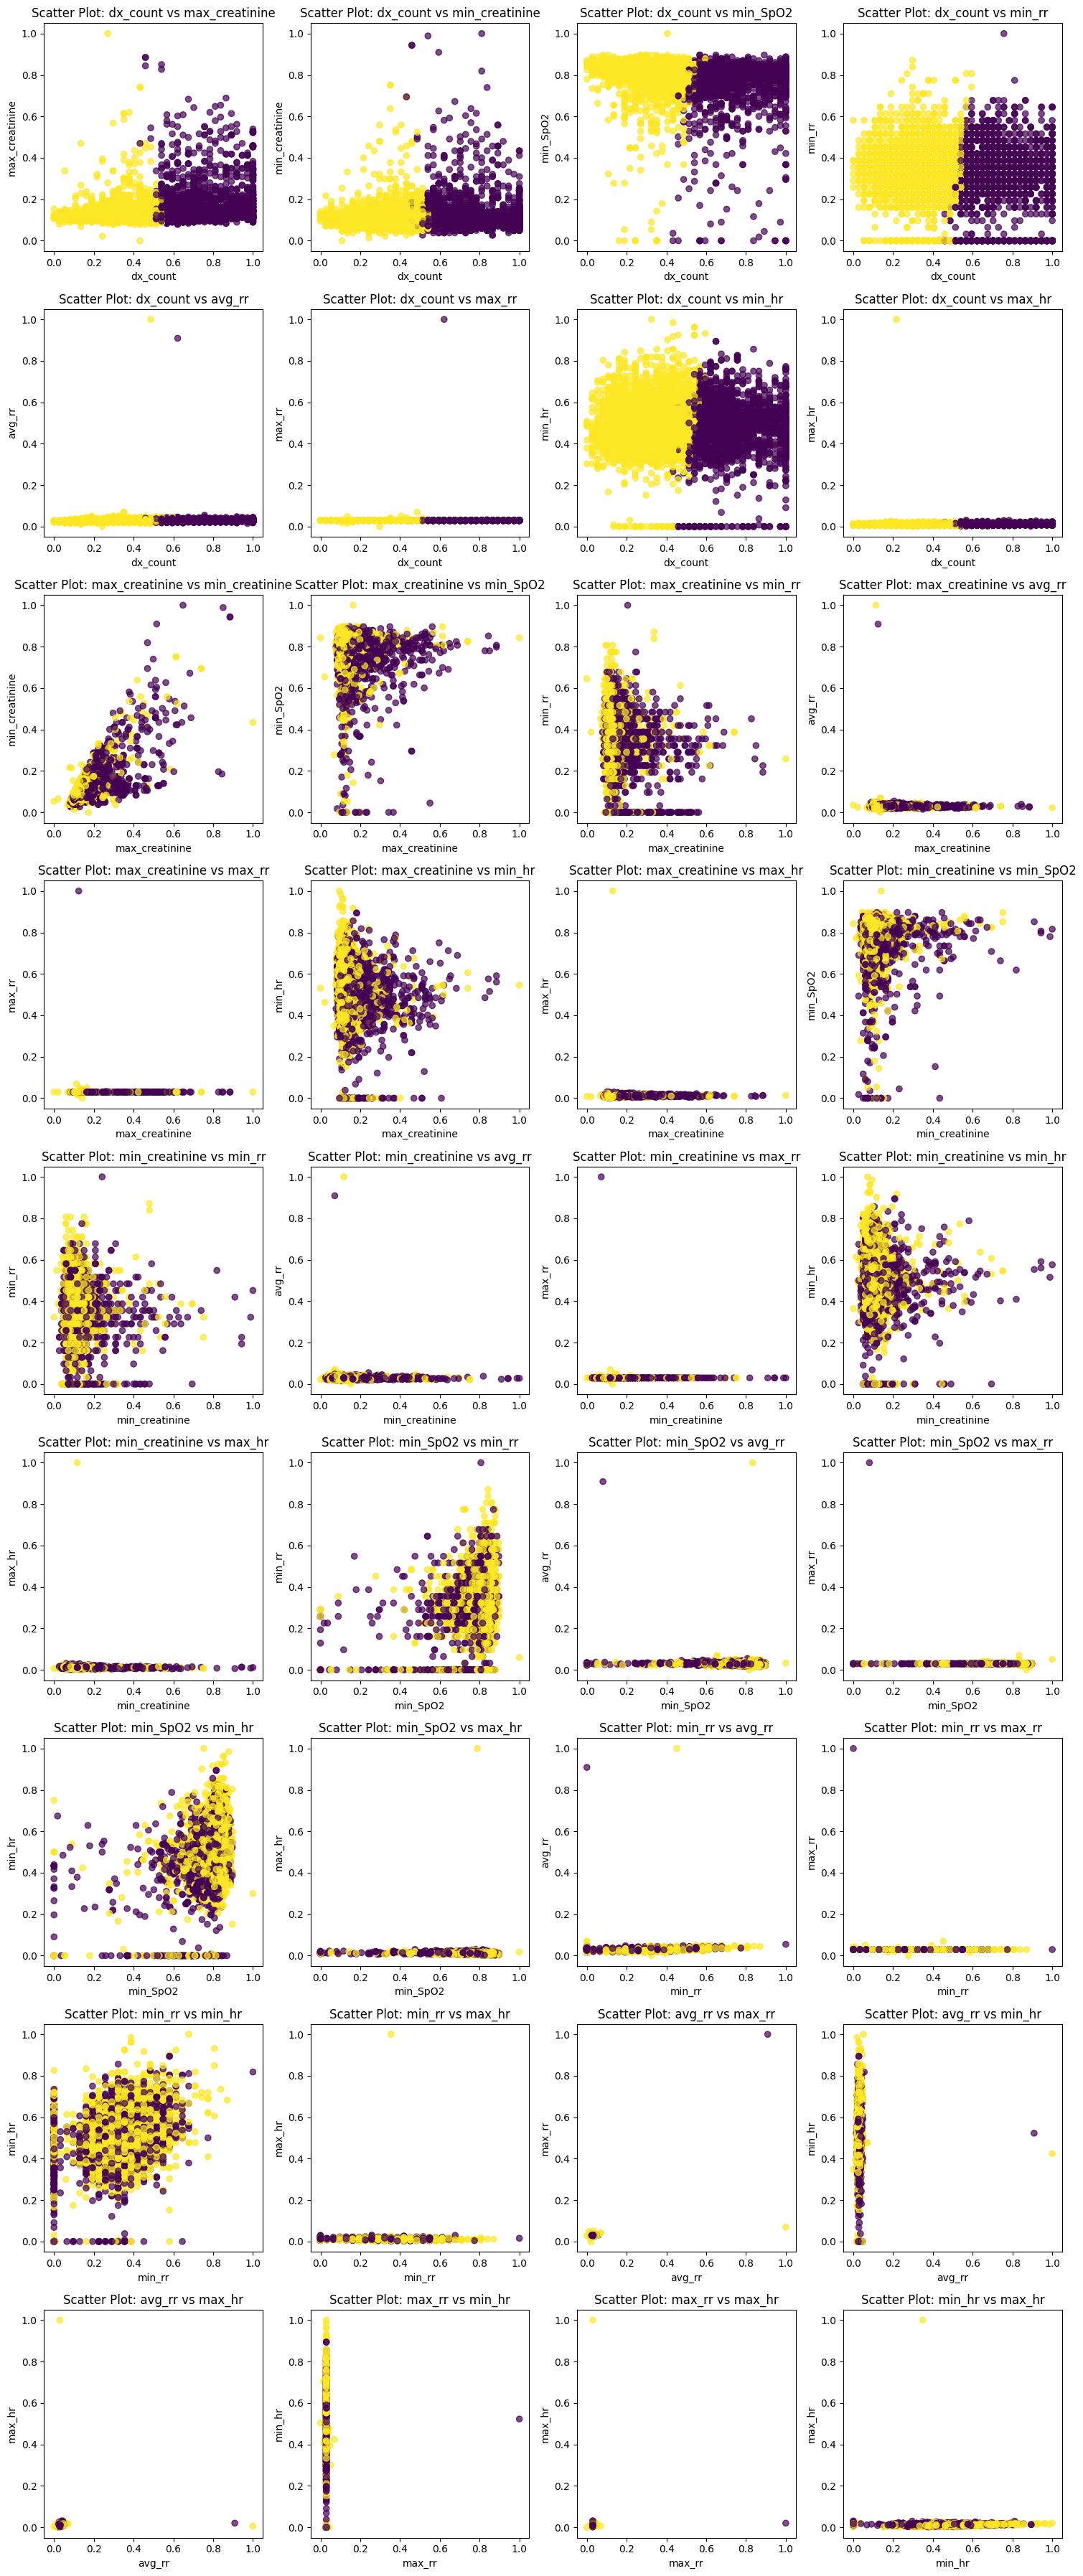

In [46]:
from itertools import combinations


# Get all possible pairs of features from the list
feature_combinations = list(combinations(focus_features, 2))

# Calculate the number of rows and columns based on the number of feature combinations
n_combinations = len(feature_combinations)
n_cols = 4  # Adjust the number of columns
n_rows = np.ceil(n_combinations / n_cols).astype(int)

# Create a larger grid of scatter plots
plt.figure(figsize=(15, n_rows * 4))

# Loop through each combination of features
for i, (feature1, feature2) in enumerate(feature_combinations, 1):
    plt.subplot(n_rows, n_cols, i)  # Adjusting the grid to fit all subplots
    plt.scatter(norm_icu_sp[feature1], norm_icu_sp[feature2], c=norm_icu_sp['reg_cluster'], cmap='viridis', alpha=0.7)
    
    # Add titles and labels
    plt.title(f'Scatter Plot: {feature1} vs {feature2}')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


Now we will look at which features are in each cluster by observing their centroids:

In [47]:
# Get the centroids of the clusters
centroids = kmeans.cluster_centers_

# Create a DataFrame with feature names and centroid values
centroid_df = pd.DataFrame(centroids, columns=focus_features)

# Display the centroids for each cluster
print(centroid_df)


   dx_count  max_creatinine  min_creatinine  min_SpO2    min_rr    avg_rr  \
0  0.735800        0.177252        0.126648  0.765673  0.290467  0.029987   
1  0.319989        0.127831        0.107832  0.807025  0.333111  0.028005   

     max_rr    min_hr    max_hr  
0  0.029984  0.470794  0.012198  
1  0.029501  0.500130  0.011055  


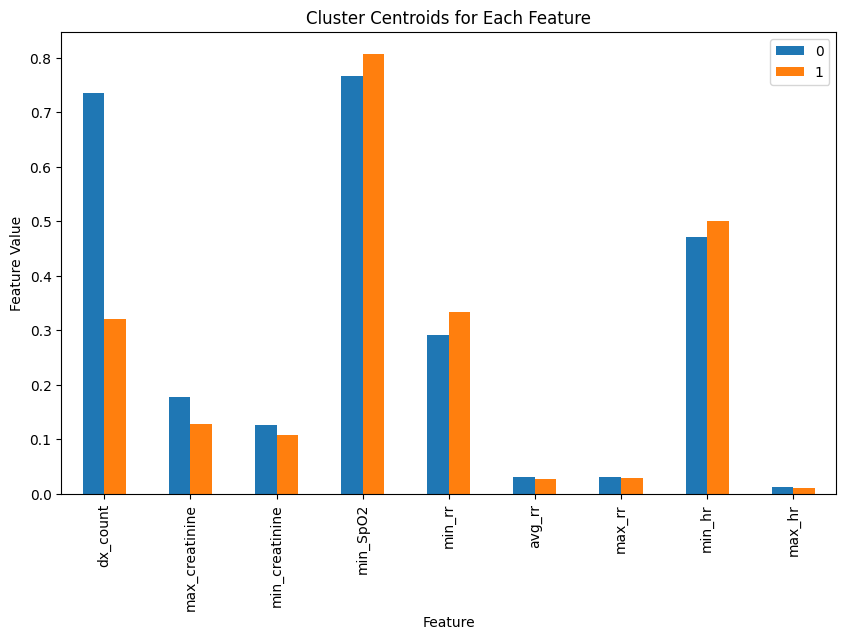

In [48]:
centroid_df.T.plot(kind='bar', figsize=(10, 6))
plt.title('Cluster Centroids for Each Feature')
plt.ylabel('Feature Value')
plt.xlabel('Feature')
plt.show()


Using our visualizations, we can see that:

- Cluster 1: has more dx_count, max_creatinine, min_creatinine
- Cluster 0: has more min_SpO2, min_rr, min_hr
- Both: had similar avg_rr, max_rr, max_hr

We can also see that dx_count has the greatest difference for each cluster, likely causing los to be high for cluster 1, so we will need to create niche machine learning models based on dx_count.



Let's have a look at dx_count vs length of stay visually:

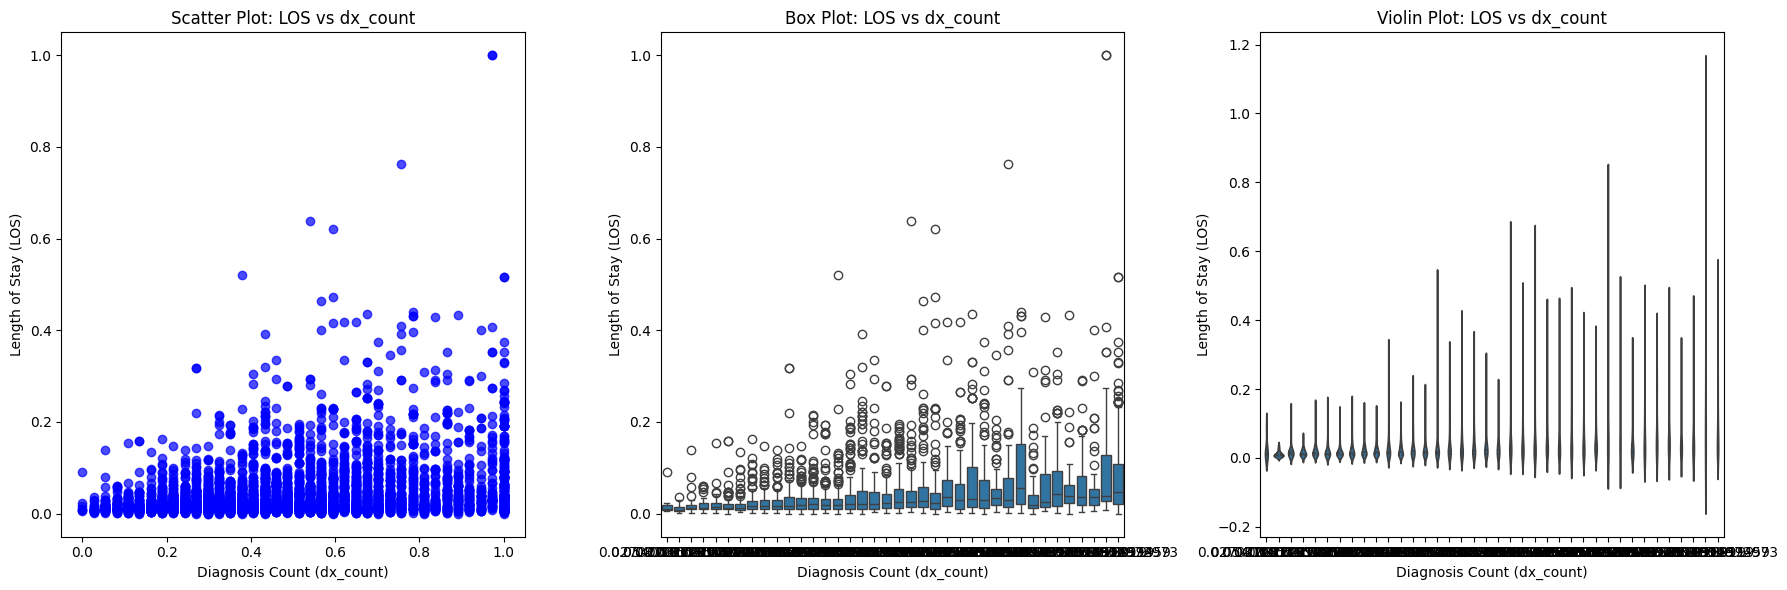

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 1x3 grid for the plots (1 row, 3 columns)
plt.figure(figsize=(18, 6))

# Scatter Plot (LOS vs dx_count)
plt.subplot(1, 3, 1)
plt.scatter(norm_icu_sp['dx_count'], norm_icu_sp['los'], alpha=0.7, color='b')
plt.title('Scatter Plot: LOS vs dx_count')
plt.xlabel('Diagnosis Count (dx_count)')
plt.ylabel('Length of Stay (LOS)')

# Box Plot (LOS vs dx_count)
plt.subplot(1, 3, 2)
sns.boxplot(data=norm_icu_sp, x='dx_count', y='los')
plt.title('Box Plot: LOS vs dx_count')
plt.xlabel('Diagnosis Count (dx_count)')
plt.ylabel('Length of Stay (LOS)')

# Violin Plot (LOS vs dx_count)
plt.subplot(1, 3, 3)
sns.violinplot(data=norm_icu_sp, x='dx_count', y='los', inner='quart')
plt.title('Violin Plot: LOS vs dx_count')
plt.xlabel('Diagnosis Count (dx_count)')
plt.ylabel('Length of Stay (LOS)')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


We note that dx_count has a directly proportional relationship with length of stay, further motivating our split into more niche machine learning models.

In [50]:
# Print the mean of dx_count for each cluster
print("Mean of dx_count for each cluster:")
print(cluster_means_new.loc['dx_count'])

Mean of dx_count for each cluster:
new_cluster
0    0.460661
1    0.446801
2    0.557480
Name: dx_count, dtype: float64


In [52]:
norm_icu_sp['new_cluster'].to_csv('clusters.csv', index=False)
